In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

C:\Users\16192\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#reading in CO hotspot with features
#classified into COs and CO hotspots
df = pd.read_csv('final_COhotspot_single_CO_withrate_v4.bed', sep='\t')
df.head()
df.columns = ["chrom", "start", "end", "Occupancy", "CG%", "CHG%", "Type", "Indel Density", "distCent", "distTelo", "distProm", "MLH3", "SNP_Density", "Rate"]
display(df)

,chrom,start,end,Occupancy,CG%,CHG%,Type,Indel Density,distCent,distTelo,distProm,MLH3,SNP_Density,Rate
0,3,603603,617270,0.017920,85.973217,64.489587,single_CO,0.006366,87782730.0,603603,18,19,0.020121,1
1,6,664320,666471,0.026094,37.164453,24.893589,single_CO,0.049279,31583529.0,664320,12,14,0.031613,1
2,9,740745,742306,NaN,13.445771,20.323887,single_CO,0.033953,33407694.0,740745,15,16,0.040359,1
3,3,751490,762638,0.016145,64.674881,38.162263,single_CO,0.022156,87637362.0,751490,23,21,0.021259,1
4,3,753234,763264,0.015044,67.045717,41.845381,single_CO,0.016451,87636736.0,753234,24,21,0.020937,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7215,1,300940464,300954657,0.016153,24.364555,13.798589,Hotspots,0.018460,173940464.0,6101253,6584,4637,0.038751,10
7216,1,301293728,301303332,0.022078,20.213609,2.351296,Hotspots,0.013536,174293728.0,5747989,6603,4650,0.032591,6
7217,1,304511350,304526834,0.012868,37.247137,27.070728,Hotspots,0.021183,177511350.0,2530367,6720,4712,0.039848,7
7218,1,305013942,305020232,0.029454,8.816116,0.267764,Hotspots,0.017011,178013942.0,2027775,6741,4721,0.023847,20


In [3]:
#dealing with missing data, usually as NA
#df.replace('NA', 'NaN', regex = True, inplace = True)
df.dropna(inplace=True)
df.head()

,chrom,start,end,Occupancy,CG%,CHG%,Type,Indel Density,distCent,distTelo,distProm,MLH3,SNP_Density,Rate
0,3,603603,617270,0.017920,85.973217,64.489587,single_CO,0.006366,87782730.0,603603,18,19,0.020121,1
1,6,664320,666471,0.026094,37.164453,24.893589,single_CO,0.049279,31583529.0,664320,12,14,0.031613,1
3,3,751490,762638,0.016145,64.674881,38.162263,single_CO,0.022156,87637362.0,751490,23,21,0.021259,1
4,3,753234,763264,0.015044,67.045717,41.845381,single_CO,0.016451,87636736.0,753234,24,21,0.020937,1
5,3,763256,767941,0.010875,20.439038,7.470990,single_CO,0.033725,87632059.0,763256,25,21,0.040342,1


In [4]:
#split into independent and dependent data
#predict col vs columns we use to predict
#y = want to predict
#X = columns we use to predict
X = df.drop(['Type','chrom','start', 'end','SNP_Density','Rate'], axis = 1).copy()
y = df['Type'].copy()

#to check it looks right
X.head()

,Occupancy,CG%,CHG%,Indel Density,distCent,distTelo,distProm,MLH3
0,0.017920,85.973217,64.489587,0.006366,87782730.0,603603,18,19
1,0.026094,37.164453,24.893589,0.049279,31583529.0,664320,12,14
3,0.016145,64.674881,38.162263,0.022156,87637362.0,751490,23,21
4,0.015044,67.045717,41.845381,0.016451,87636736.0,753234,24,21
5,0.010875,20.439038,7.470990,0.033725,87632059.0,763256,25,21


In [6]:
#One hot encoding: categorical splitting i.e. with 0 or 1 for each categority subtype
#tells us whether float or categorical
#this should all be float!
X.dtypes

Occupancy        float64
CG%              float64
CHG%             float64
Indel Density    float64
distCent         float64
distTelo           int64
distProm           int64
MLH3               int64
dtype: object

In [17]:
#split into training and testing set
#need to stratify?
sum(df['Type'] == 'single_CO') / sum(df['Type'] == 'Hotspots')
#more single COs than hotspots, ~12% are hotspots
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

In [10]:
#take out NA and Inf from datasets
X_train[~X_train.isin([np.nan, np.inf, -np.inf]).any(1)]
X_test[~X_test.isin([np.nan, np.inf, -np.inf]).any(1)]

#filter y based on whats left in X
y_train = y_train[y_train.index.isin(X_train.index)]
y_test = y_test[y_test.index.isin(X_test.index)]

4991

In [12]:
#building actual model
crossover_xgb = xgb.XGBClassifier(objective='binary:logistic', seed = 100)
crossover_xgb.fit(X_train, y_train, 
                  verbose = True, 
                  early_stopping_rounds = 10, 
                  eval_metric = 'aucpr', 
                  eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.95841
[1]	validation_0-aucpr:0.96510
[2]	validation_0-aucpr:0.96482
[3]	validation_0-aucpr:0.96553
[4]	validation_0-aucpr:0.96531
[5]	validation_0-aucpr:0.96494
[6]	validation_0-aucpr:0.96371
[7]	validation_0-aucpr:0.96364
[8]	validation_0-aucpr:0.96439
[9]	validation_0-aucpr:0.96349
[10]	validation_0-aucpr:0.96357
[11]	validation_0-aucpr:0.96433
[12]	validation_0-aucpr:0.96475
[13]	validation_0-aucpr:0.96622
[14]	validation_0-aucpr:0.96626
[15]	validation_0-aucpr:0.96613
[16]	validation_0-aucpr:0.96549
[17]	validation_0-aucpr:0.96499


C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18]	validation_0-aucpr:0.96573
[19]	validation_0-aucpr:0.96622
[20]	validation_0-aucpr:0.96581
[21]	validation_0-aucpr:0.96570
[22]	validation_0-aucpr:0.96644
[23]	validation_0-aucpr:0.96688
[24]	validation_0-aucpr:0.96712
[25]	validation_0-aucpr:0.96726
[26]	validation_0-aucpr:0.96717
[27]	validation_0-aucpr:0.96696
[28]	validation_0-aucpr:0.96583
[29]	validation_0-aucpr:0.96632
[30]	validation_0-aucpr:0.96573
[31]	validation_0-aucpr:0.96535
[32]	validation_0-aucpr:0.96578
[33]	validation_0-aucpr:0.96566
[34]	validation_0-aucpr:0.96530


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

C:\Users\16192\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


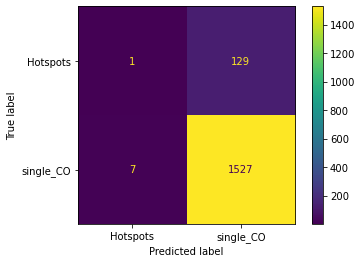

In [13]:
#now lets see how it performs on testing datset & making confusion matrix
plot_confusion_matrix(crossover_xgb, X_test, y_test, values_format='d', display_labels=['Hotspots', 'single_CO'])
#plt.savefig('confusion_matrix_before.png',dpi=300)

In [14]:
#optimize parameters, if needed
#scale_pos_weight for imbalanced data sets
#use GridSearch to find optimal hyperparameters
param_grid = {'scale_pos_weight': [0.10, 0.169, 0.25], 'max_depth': [3,4,5], 'learning_rate':[0.1,0.01,0.05],
              'gamma':[0,0.25,1]}
optimal = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', subsample = 0.9, colsample_bytree =0.5, seed = 100), param_grid = param_grid, scoring = 'roc_auc', verbose = 2, cv = 3)
optimal.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric ='auc', eval_set = [(X_test,y_test)])
print(optimal.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[0]	validation_0-auc:0.65628
[1]	validation_0-auc:0.67893
[2]	validation_0-auc:0.71620
[3]	validation_0-auc:0.72896
[4]	validation_0-auc:0.72847
[5]	validation_0-auc:0.72872
[6]	validation_0-auc:0.73585
[7]	validation_0-auc:0.74540
[8]	validation_0-auc:0.74650
[9]	validation_0-auc:0.74897
[10]	validation_0-auc:0.74374
[11]	validation_0-auc:0.74380
[12]	validation_0-auc:0.74482
[13]	validation_0-auc:0.74505
[14]	validation_0-auc:0.74791
[15]	validation_0-auc:0.74998
[16]	validation_0-auc:0.74966
[17]	validation_0-auc:0.74978
[18]	validation_0-auc:0.75040
[19]	validation_0-auc:0.74970
[20]	validation_0-auc:0.75142
[21]	validation_0-auc:0.75030
[22]	validation_0-auc:0.74878
[23]	validation_0-auc:0.74730
[24]	validation_0-auc:0.74505
[25]	validation_0-auc:0.74486
[26]	validation_0-auc:0.74538
[27]	validation_0-auc:0.74683
[28]	validation_0-auc:0.74766
[29]	validation_0-auc:0.74794
[CV] END gamma=0, learning_rate=0.1, max_depth=3

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[22]	validation_0-auc:0.74433
[23]	validation_0-auc:0.74354
[24]	validation_0-auc:0.74319
[25]	validation_0-auc:0.74446
[26]	validation_0-auc:0.74426
[27]	validation_0-auc:0.74396
[28]	validation_0-auc:0.74298
[29]	validation_0-auc:0.74322
[CV] END gamma=0, learning_rate=0.1, max_depth=3, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.63730
[1]	validation_0-auc:0.68109
[2]	validation_0-auc:0.70343
[3]	validation_0-auc:0.71261
[4]	validation_0-auc:0.72447
[5]	validation_0-auc:0.72637
[6]	validation_0-auc:0.72613
[7]	validation_0-auc:0.73181
[8]	validation_0-auc:0.73357
[9]	validation_0-auc:0.73865
[10]	validation_0-auc:0.74105
[11]	validation_0-auc:0.74296
[12]	validation_0-auc:0.74630
[13]	validation_0-auc:0.74551
[14]	validation_0-auc:0.74744
[15]	validation_0-auc:0.74396
[16]	validation_0-auc:0.74606
[17]	validation_0-auc:0.74414
[18]	validation_0-auc:0.74587
[19]	validation_0-auc:0.74695
[20]	validation_0-auc:0.74648
[21]	validation_0-auc:0.74738
[22]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[65]	validation_0-auc:0.76379
[CV] END gamma=0, learning_rate=0.1, max_depth=3, scale_pos_weight=0.1; total time=   0.1s
[0]	validation_0-auc:0.65440
[1]	validation_0-auc:0.67374
[2]	validation_0-auc:0.71694
[3]	validation_0-auc:0.73225
[4]	validation_0-auc:0.73168
[5]	validation_0-auc:0.72883
[6]	validation_0-auc:0.73556
[7]	validation_0-auc:0.74316
[8]	validation_0-auc:0.74332
[9]	validation_0-auc:0.74353
[10]	validation_0-auc:0.73923
[11]	validation_0-auc:0.74278
[12]	validation_0-auc:0.74125
[13]	validation_0-auc:0.74263
[14]	validation_0-auc:0.74347
[15]	validation_0-auc:0.74547
[16]	validation_0-auc:0.74679
[17]	validation_0-auc:0.74756
[18]	validation_0-auc:0.74804
[19]	validation_0-auc:0.74796
[20]	validation_0-auc:0.75015
[21]	validation_0-auc:0.74848
[22]	validation_0-auc:0.74514
[23]	validation_0-auc:0.74492
[24]	validation_0-auc:0.74305
[25]	validation_0-auc:0.74331
[26]	validation_0-auc:0.74363
[27]	validation_0-auc:0.74441
[28]	validation_0-auc:0.74533
[29]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[26]	validation_0-auc:0.74146
[27]	validation_0-auc:0.74067
[28]	validation_0-auc:0.73972
[29]	validation_0-auc:0.74003
[30]	validation_0-auc:0.74031
[31]	validation_0-auc:0.74159
[32]	validation_0-auc:0.74148
[33]	validation_0-auc:0.74166
[34]	validation_0-auc:0.74239
[35]	validation_0-auc:0.74292
[36]	validation_0-auc:0.74326
[37]	validation_0-auc:0.74430
[38]	validation_0-auc:0.74326
[39]	validation_0-auc:0.74198
[40]	validation_0-auc:0.74253
[41]	validation_0-auc:0.74363
[42]	validation_0-auc:0.74366
[43]	validation_0-auc:0.74310
[44]	validation_0-auc:0.74212
[45]	validation_0-auc:0.74215
[46]	validation_0-auc:0.74223
[47]	validation_0-auc:0.74231
[CV] END gamma=0, learning_rate=0.1, max_depth=3, scale_pos_weight=0.169; total time=   0.1s
[0]	validation_0-auc:0.66672
[1]	validation_0-auc:0.68325
[2]	validation_0-auc:0.69481
[3]	validation_0-auc:0.72036
[4]	validation_0-auc:0.72428
[5]	validation_0-auc:0.72765
[6]	validation_0-auc:0.73051
[7]	validation_0-auc:0.73342
[8]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[72]	validation_0-auc:0.76076
[73]	validation_0-auc:0.76145
[74]	validation_0-auc:0.76182
[75]	validation_0-auc:0.76218
[76]	validation_0-auc:0.76259
[77]	validation_0-auc:0.76141
[78]	validation_0-auc:0.76182
[79]	validation_0-auc:0.76156
[80]	validation_0-auc:0.76117
[81]	validation_0-auc:0.76193
[82]	validation_0-auc:0.76143
[83]	validation_0-auc:0.76144
[84]	validation_0-auc:0.76232
[85]	validation_0-auc:0.76245
[86]	validation_0-auc:0.76244
[CV] END gamma=0, learning_rate=0.1, max_depth=3, scale_pos_weight=0.169; total time=   0.2s
[0]	validation_0-auc:0.63996
[1]	validation_0-auc:0.66612
[2]	validation_0-auc:0.70802
[3]	validation_0-auc:0.71378
[4]	validation_0-auc:0.71972
[5]	validation_0-auc:0.71292
[6]	validation_0-auc:0.72121
[7]	validation_0-auc:0.72864
[8]	validation_0-auc:0.73131
[9]	validation_0-auc:0.73429
[10]	validation_0-auc:0.72707
[11]	validation_0-auc:0.73058
[12]	validation_0-auc:0.72991
[13]	validation_0-auc:0.73178
[14]	validation_0-auc:0.73502
[15]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END gamma=0, learning_rate=0.1, max_depth=3, scale_pos_weight=0.25; total time=   0.1s
[0]	validation_0-auc:0.66829
[1]	validation_0-auc:0.68691
[2]	validation_0-auc:0.70178
[3]	validation_0-auc:0.70811
[4]	validation_0-auc:0.71239
[5]	validation_0-auc:0.72120
[6]	validation_0-auc:0.72783
[7]	validation_0-auc:0.73242
[8]	validation_0-auc:0.73221
[9]	validation_0-auc:0.73252
[10]	validation_0-auc:0.72634
[11]	validation_0-auc:0.73190
[12]	validation_0-auc:0.73080
[13]	validation_0-auc:0.72941
[14]	validation_0-auc:0.73173
[15]	validation_0-auc:0.73192
[16]	validation_0-auc:0.73462
[17]	validation_0-auc:0.73548
[18]	validation_0-auc:0.73560
[19]	validation_0-auc:0.73725
[20]	validation_0-auc:0.74033
[21]	validation_0-auc:0.73945
[22]	validation_0-auc:0.73852
[23]	validation_0-auc:0.73826
[24]	validation_0-auc:0.73755
[25]	validation_0-auc:0.73882
[26]	validation_0-auc:0.73909
[27]	validation_0-auc:0.73876
[28]	validation_0-auc:0.73764
[29]	validation_0-auc:0.73768
[30]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[21]	validation_0-auc:0.74252
[22]	validation_0-auc:0.74283
[23]	validation_0-auc:0.74319
[24]	validation_0-auc:0.74454
[25]	validation_0-auc:0.74559
[26]	validation_0-auc:0.74529
[27]	validation_0-auc:0.74677
[28]	validation_0-auc:0.74940
[29]	validation_0-auc:0.75197
[30]	validation_0-auc:0.75329
[31]	validation_0-auc:0.75199
[32]	validation_0-auc:0.75148
[33]	validation_0-auc:0.75207
[34]	validation_0-auc:0.75294
[35]	validation_0-auc:0.75307
[36]	validation_0-auc:0.75591
[37]	validation_0-auc:0.75544
[38]	validation_0-auc:0.75651
[39]	validation_0-auc:0.75723
[40]	validation_0-auc:0.75703
[41]	validation_0-auc:0.75818
[42]	validation_0-auc:0.75875
[43]	validation_0-auc:0.75850
[44]	validation_0-auc:0.75826
[45]	validation_0-auc:0.75997
[46]	validation_0-auc:0.76050
[47]	validation_0-auc:0.76054
[48]	validation_0-auc:0.76084
[49]	validation_0-auc:0.76134
[50]	validation_0-auc:0.76252
[51]	validation_0-auc:0.76248
[52]	validation_0-auc:0.76435
[53]	validation_0-auc:0.76499
[54]	valid

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[21]	validation_0-auc:0.74434
[22]	validation_0-auc:0.74570
[23]	validation_0-auc:0.74518
[24]	validation_0-auc:0.74382
[25]	validation_0-auc:0.74182
[26]	validation_0-auc:0.74145
[27]	validation_0-auc:0.73983
[28]	validation_0-auc:0.73926
[29]	validation_0-auc:0.74018
[30]	validation_0-auc:0.74142
[31]	validation_0-auc:0.74245
[32]	validation_0-auc:0.74225
[CV] END gamma=0, learning_rate=0.1, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65138
[1]	validation_0-auc:0.69941
[2]	validation_0-auc:0.73013
[3]	validation_0-auc:0.72953
[4]	validation_0-auc:0.73329
[5]	validation_0-auc:0.73388
[6]	validation_0-auc:0.73790
[7]	validation_0-auc:0.74051
[8]	validation_0-auc:0.73776
[9]	validation_0-auc:0.73756
[10]	validation_0-auc:0.73923
[11]	validation_0-auc:0.74050
[12]	validation_0-auc:0.74348
[13]	validation_0-auc:0.74562
[14]	validation_0-auc:0.74813
[15]	validation_0-auc:0.74962
[16]	validation_0-auc:0.74982
[17]	validation_0-auc:0.74677
[18]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.64820
[1]	validation_0-auc:0.67663
[2]	validation_0-auc:0.70662
[3]	validation_0-auc:0.71376
[4]	validation_0-auc:0.71769
[5]	validation_0-auc:0.71449
[6]	validation_0-auc:0.72218
[7]	validation_0-auc:0.72780
[8]	validation_0-auc:0.73196
[9]	validation_0-auc:0.73171
[10]	validation_0-auc:0.73409
[11]	validation_0-auc:0.73716
[12]	validation_0-auc:0.73637
[13]	validation_0-auc:0.73894
[14]	validation_0-auc:0.74104
[15]	validation_0-auc:0.74193
[16]	validation_0-auc:0.74535
[17]	validation_0-auc:0.74345
[18]	validation_0-auc:0.74659
[19]	validation_0-auc:0.74494
[20]	validation_0-auc:0.74551
[21]	validation_0-auc:0.74557
[22]	validation_0-auc:0.74633
[23]	validation_0-auc:0.74458
[24]	validation_0-auc:0.74177
[25]	validation_0-auc:0.74204
[26]	validation_0-auc:0.74271
[27]	validation_0-auc:0.74425
[CV] END gamma=0, learning_rate=0.1, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.65657
[1]	validation_0-auc:0.68343
[2]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[23]	validation_0-auc:0.73848
[24]	validation_0-auc:0.73792
[25]	validation_0-auc:0.73682
[26]	validation_0-auc:0.73613
[27]	validation_0-auc:0.73467
[28]	validation_0-auc:0.73520
[29]	validation_0-auc:0.73560
[30]	validation_0-auc:0.73724
[31]	validation_0-auc:0.73896
[CV] END gamma=0, learning_rate=0.1, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.66524
[1]	validation_0-auc:0.69750
[2]	validation_0-auc:0.73271
[3]	validation_0-auc:0.73113
[4]	validation_0-auc:0.73513
[5]	validation_0-auc:0.73970
[6]	validation_0-auc:0.73865
[7]	validation_0-auc:0.73885
[8]	validation_0-auc:0.73984
[9]	validation_0-auc:0.74005
[10]	validation_0-auc:0.74110
[11]	validation_0-auc:0.74313
[12]	validation_0-auc:0.74463
[13]	validation_0-auc:0.74686
[14]	validation_0-auc:0.74886
[15]	validation_0-auc:0.74724
[16]	validation_0-auc:0.74751
[17]	validation_0-auc:0.74419
[18]	validation_0-auc:0.74616
[19]	validation_0-auc:0.74774
[20]	validation_0-auc:0.74769
[21]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[59]	validation_0-auc:0.75886
[60]	validation_0-auc:0.75867
[61]	validation_0-auc:0.75883
[62]	validation_0-auc:0.75805
[63]	validation_0-auc:0.75828
[64]	validation_0-auc:0.75835
[65]	validation_0-auc:0.75824
[66]	validation_0-auc:0.75797
[67]	validation_0-auc:0.75889
[68]	validation_0-auc:0.75816
[69]	validation_0-auc:0.75889
[70]	validation_0-auc:0.75860
[71]	validation_0-auc:0.75766
[72]	validation_0-auc:0.75716
[73]	validation_0-auc:0.75716
[74]	validation_0-auc:0.75768
[75]	validation_0-auc:0.75776
[76]	validation_0-auc:0.75771
[77]	validation_0-auc:0.75619
[78]	validation_0-auc:0.75632
[CV] END gamma=0, learning_rate=0.1, max_depth=4, scale_pos_weight=0.169; total time=   0.2s
[0]	validation_0-auc:0.62799
[1]	validation_0-auc:0.65870
[2]	validation_0-auc:0.69041
[3]	validation_0-auc:0.69988
[4]	validation_0-auc:0.70571
[5]	validation_0-auc:0.70178
[6]	validation_0-auc:0.71205
[7]	validation_0-auc:0.72047
[8]	validation_0-auc:0.72452
[9]	validation_0-auc:0.72654
[10]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.66205
[1]	validation_0-auc:0.68756
[2]	validation_0-auc:0.70611
[3]	validation_0-auc:0.70499
[4]	validation_0-auc:0.71356
[5]	validation_0-auc:0.71598
[6]	validation_0-auc:0.72419
[7]	validation_0-auc:0.72899
[8]	validation_0-auc:0.72884
[9]	validation_0-auc:0.73170
[10]	validation_0-auc:0.73404
[11]	validation_0-auc:0.73586
[12]	validation_0-auc:0.73322
[13]	validation_0-auc:0.73386
[14]	validation_0-auc:0.73297
[15]	validation_0-auc:0.73191
[16]	validation_0-auc:0.73275
[17]	validation_0-auc:0.73261
[18]	validation_0-auc:0.73148
[19]	validation_0-auc:0.73219
[20]	validation_0-auc:0.73391
[21]	validation_0-auc:0.73567
[CV] END gamma=0, learning_rate=0.1, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.67228
[1]	validation_0-auc:0.69709
[2]	validation_0-auc:0.72020
[3]	validation_0-auc:0.72651
[4]	validation_0-auc:0.72870
[5]	validation_0-auc:0.73392
[6]	validation_0-auc:0.73520
[7]	validation_0-auc:0.73882
[8]	validation_0-auc:0.737

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0, learning_rate=0.1, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.64745
[1]	validation_0-auc:0.67178
[2]	validation_0-auc:0.70899
[3]	validation_0-auc:0.72389
[4]	validation_0-auc:0.72989
[5]	validation_0-auc:0.72682
[6]	validation_0-auc:0.73255
[7]	validation_0-auc:0.73711
[8]	validation_0-auc:0.73942
[9]	validation_0-auc:0.74397
[10]	validation_0-auc:0.74537
[11]	validation_0-auc:0.74573
[12]	validation_0-auc:0.74511
[13]	validation_0-auc:0.74653
[14]	validation_0-auc:0.74901
[15]	validation_0-auc:0.74895
[16]	validation_0-auc:0.74809
[17]	validation_0-auc:0.74728
[18]	validation_0-auc:0.75059
[19]	validation_0-auc:0.74965
[20]	validation_0-auc:0.74819
[21]	validation_0-auc:0.74845
[22]	validation_0-auc:0.74847
[23]	validation_0-auc:0.74834
[24]	validation_0-auc:0.74699
[25]	validation_0-auc:0.74688
[26]	validation_0-auc:0.74636
[27]	validation_0-auc:0.74802
[28]	validation_0-auc:0.74759
[CV] END gamma=0, learning_rate=0.1, max_depth=5

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[15]	validation_0-auc:0.74275
[16]	validation_0-auc:0.74339
[17]	validation_0-auc:0.74493
[18]	validation_0-auc:0.74259
[CV] END gamma=0, learning_rate=0.1, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.67502
[1]	validation_0-auc:0.71010
[2]	validation_0-auc:0.73418
[3]	validation_0-auc:0.73789
[4]	validation_0-auc:0.74682
[5]	validation_0-auc:0.75161
[6]	validation_0-auc:0.75333
[7]	validation_0-auc:0.75519
[8]	validation_0-auc:0.75444
[9]	validation_0-auc:0.75620
[10]	validation_0-auc:0.75757
[11]	validation_0-auc:0.75799
[12]	validation_0-auc:0.76035
[13]	validation_0-auc:0.76021
[14]	validation_0-auc:0.76050
[15]	validation_0-auc:0.75899
[16]	validation_0-auc:0.75952
[17]	validation_0-auc:0.75949
[18]	validation_0-auc:0.75824
[19]	validation_0-auc:0.75966
[20]	validation_0-auc:0.76031
[21]	validation_0-auc:0.75961
[22]	validation_0-auc:0.75955
[23]	validation_0-auc:0.75965
[24]	validation_0-auc:0.75904
[CV] END gamma=0, learning_rate=0.1, max_depth=5,

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh


[16]	validation_0-auc:0.74046
[17]	validation_0-auc:0.74031
[18]	validation_0-auc:0.74394
[19]	validation_0-auc:0.74208
[20]	validation_0-auc:0.74216
[21]	validation_0-auc:0.74296
[22]	validation_0-auc:0.74276
[23]	validation_0-auc:0.74213
[24]	validation_0-auc:0.74053
[25]	validation_0-auc:0.74187
[26]	validation_0-auc:0.74097
[27]	validation_0-auc:0.74317
[CV] END gamma=0, learning_rate=0.1, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.68157
[1]	validation_0-auc:0.68767
[2]	validation_0-auc:0.70930
[3]	validation_0-auc:0.71627
[4]	validation_0-auc:0.72426
[5]	validation_0-auc:0.72873
[6]	validation_0-auc:0.73680
[7]	validation_0-auc:0.74040
[8]	validation_0-auc:0.73818
[9]	validation_0-auc:0.74476
[10]	validation_0-auc:0.74833
[11]	validation_0-auc:0.75275
[12]	validation_0-auc:0.74591
[13]	validation_0-auc:0.74524
[14]	validation_0-auc:0.74410
[15]	validation_0-auc:0.74351
[16]	validation_0-auc:0.74342
[17]	validation_0-auc:0.74121
[18]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[18]	validation_0-auc:0.74716
[19]	validation_0-auc:0.74819
[20]	validation_0-auc:0.74821
[21]	validation_0-auc:0.74718
[22]	validation_0-auc:0.74869
[23]	validation_0-auc:0.75033
[24]	validation_0-auc:0.74847
[25]	validation_0-auc:0.74935
[CV] END gamma=0, learning_rate=0.1, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.63801
[1]	validation_0-auc:0.64612
[2]	validation_0-auc:0.68824
[3]	validation_0-auc:0.70143
[4]	validation_0-auc:0.71144
[5]	validation_0-auc:0.70836
[6]	validation_0-auc:0.71606
[7]	validation_0-auc:0.72517
[8]	validation_0-auc:0.73113
[9]	validation_0-auc:0.73037
[10]	validation_0-auc:0.73489
[11]	validation_0-auc:0.73766
[12]	validation_0-auc:0.73631
[13]	validation_0-auc:0.73909
[14]	validation_0-auc:0.74195
[15]	validation_0-auc:0.74205
[16]	validation_0-auc:0.74501
[17]	validation_0-auc:0.74475
[18]	validation_0-auc:0.74923
[19]	validation_0-auc:0.74641
[20]	validation_0-auc:0.74622
[21]	validation_0-auc:0.74428
[22]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[10]	validation_0-auc:0.73733
[11]	validation_0-auc:0.73735
[12]	validation_0-auc:0.73527
[13]	validation_0-auc:0.73615
[14]	validation_0-auc:0.73587
[15]	validation_0-auc:0.73428
[16]	validation_0-auc:0.73569
[17]	validation_0-auc:0.73713
[18]	validation_0-auc:0.73452
[19]	validation_0-auc:0.73341
[CV] END gamma=0, learning_rate=0.1, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.70252
[1]	validation_0-auc:0.72228
[2]	validation_0-auc:0.73192
[3]	validation_0-auc:0.73063
[4]	validation_0-auc:0.73367
[5]	validation_0-auc:0.73556
[6]	validation_0-auc:0.73572
[7]	validation_0-auc:0.73906
[8]	validation_0-auc:0.73943
[9]	validation_0-auc:0.73824
[10]	validation_0-auc:0.74034
[11]	validation_0-auc:0.73981
[12]	validation_0-auc:0.74243
[13]	validation_0-auc:0.74368
[14]	validation_0-auc:0.74496
[15]	validation_0-auc:0.74158
[16]	validation_0-auc:0.74311
[17]	validation_0-auc:0.73941
[18]	validation_0-auc:0.73953
[19]	validation_0-auc:0.74037
[20]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[50]	validation_0-auc:0.75237
[51]	validation_0-auc:0.75225
[52]	validation_0-auc:0.75125
[53]	validation_0-auc:0.75124
[54]	validation_0-auc:0.75136
[55]	validation_0-auc:0.75082
[56]	validation_0-auc:0.75135
[57]	validation_0-auc:0.75123
[58]	validation_0-auc:0.75110
[CV] END gamma=0, learning_rate=0.1, max_depth=5, scale_pos_weight=0.25; total time=   0.1s
[0]	validation_0-auc:0.65628
[1]	validation_0-auc:0.68474
[2]	validation_0-auc:0.70882
[3]	validation_0-auc:0.72086
[4]	validation_0-auc:0.73316
[5]	validation_0-auc:0.73044
[6]	validation_0-auc:0.73181
[7]	validation_0-auc:0.74226
[8]	validation_0-auc:0.74211
[9]	validation_0-auc:0.74147
[10]	validation_0-auc:0.73846
[11]	validation_0-auc:0.73987
[12]	validation_0-auc:0.74431
[13]	validation_0-auc:0.74412
[14]	validation_0-auc:0.74479
[15]	validation_0-auc:0.74327
[16]	validation_0-auc:0.74358
[17]	validation_0-auc:0.74206
[18]	validation_0-auc:0.74299
[19]	validation_0-auc:0.74319
[20]	validation_0-auc:0.74567
[21]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[19]	validation_0-auc:0.73309
[20]	validation_0-auc:0.73376
[21]	validation_0-auc:0.73423
[22]	validation_0-auc:0.73121
[23]	validation_0-auc:0.73106
[24]	validation_0-auc:0.73139
[CV] END gamma=0, learning_rate=0.01, max_depth=3, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.63730
[1]	validation_0-auc:0.67886
[2]	validation_0-auc:0.69399
[3]	validation_0-auc:0.70856
[4]	validation_0-auc:0.70846
[5]	validation_0-auc:0.71076
[6]	validation_0-auc:0.71154
[7]	validation_0-auc:0.72615
[8]	validation_0-auc:0.72823
[9]	validation_0-auc:0.73452
[10]	validation_0-auc:0.73494
[11]	validation_0-auc:0.73610
[12]	validation_0-auc:0.73693
[13]	validation_0-auc:0.73641
[14]	validation_0-auc:0.73970
[15]	validation_0-auc:0.74056
[16]	validation_0-auc:0.74167
[17]	validation_0-auc:0.74150
[18]	validation_0-auc:0.74090
[19]	validation_0-auc:0.74164
[20]	validation_0-auc:0.74056
[21]	validation_0-auc:0.74168
[22]	validation_0-auc:0.74235
[23]	validation_0-auc:0.74180
[24]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[67]	validation_0-auc:0.74633
[68]	validation_0-auc:0.74648
[69]	validation_0-auc:0.74636
[70]	validation_0-auc:0.74619
[71]	validation_0-auc:0.74631
[72]	validation_0-auc:0.74616
[73]	validation_0-auc:0.74659
[74]	validation_0-auc:0.74721
[75]	validation_0-auc:0.74700
[76]	validation_0-auc:0.74734
[77]	validation_0-auc:0.74697
[78]	validation_0-auc:0.74711
[79]	validation_0-auc:0.74690
[80]	validation_0-auc:0.74672
[81]	validation_0-auc:0.74674
[82]	validation_0-auc:0.74662
[83]	validation_0-auc:0.74674
[84]	validation_0-auc:0.74686
[85]	validation_0-auc:0.74670
[86]	validation_0-auc:0.74653
[CV] END gamma=0, learning_rate=0.01, max_depth=3, scale_pos_weight=0.1; total time=   0.2s
[0]	validation_0-auc:0.65440
[1]	validation_0-auc:0.67374
[2]	validation_0-auc:0.70323
[3]	validation_0-auc:0.70878
[4]	validation_0-auc:0.71643
[5]	validation_0-auc:0.71502
[6]	validation_0-auc:0.72147
[7]	validation_0-auc:0.73090
[8]	validation_0-auc:0.73232
[9]	validation_0-auc:0.73365
[10]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[2]	validation_0-auc:0.69637
[3]	validation_0-auc:0.71010
[4]	validation_0-auc:0.70882
[5]	validation_0-auc:0.70931
[6]	validation_0-auc:0.70908
[7]	validation_0-auc:0.72093
[8]	validation_0-auc:0.72332
[9]	validation_0-auc:0.72947
[10]	validation_0-auc:0.72910
[11]	validation_0-auc:0.73071
[12]	validation_0-auc:0.73225
[13]	validation_0-auc:0.73233
[14]	validation_0-auc:0.73496
[15]	validation_0-auc:0.73459
[16]	validation_0-auc:0.73651
[17]	validation_0-auc:0.73538
[18]	validation_0-auc:0.73480
[19]	validation_0-auc:0.73533
[20]	validation_0-auc:0.73470
[21]	validation_0-auc:0.73611
[22]	validation_0-auc:0.73653
[23]	validation_0-auc:0.73620
[24]	validation_0-auc:0.73779
[25]	validation_0-auc:0.73769
[26]	validation_0-auc:0.73751
[27]	validation_0-auc:0.73784
[28]	validation_0-auc:0.73855
[29]	validation_0-auc:0.73921
[30]	validation_0-auc:0.73970
[31]	validation_0-auc:0.74002
[32]	validation_0-auc:0.74037
[33]	validation_0-auc:0.74101
[34]	validation_0-auc:0.74132
[35]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0, learning_rate=0.01, max_depth=3, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.65775
[1]	validation_0-auc:0.68081
[2]	validation_0-auc:0.69403
[3]	validation_0-auc:0.71605
[4]	validation_0-auc:0.71631
[5]	validation_0-auc:0.71876
[6]	validation_0-auc:0.71965
[7]	validation_0-auc:0.72723
[8]	validation_0-auc:0.72854
[9]	validation_0-auc:0.72491
[10]	validation_0-auc:0.72572
[11]	validation_0-auc:0.72761
[12]	validation_0-auc:0.73085
[13]	validation_0-auc:0.73246
[14]	validation_0-auc:0.73503
[15]	validation_0-auc:0.73598
[16]	validation_0-auc:0.73928
[17]	validation_0-auc:0.73718
[18]	validation_0-auc:0.73503
[19]	validation_0-auc:0.73579
[20]	validation_0-auc:0.73645
[21]	validation_0-auc:0.73673
[22]	validation_0-auc:0.73747
[23]	validation_0-auc:0.73720
[24]	validation_0-auc:0.73708
[25]	validation_0-auc:0.73711
[26]	validation_0-auc:0.73638
[CV] END gamma=0, learning_rate=0.01, max_depth=3, scale_pos_weight=0.25; total time=   0.0s
[0]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.66320
[1]	validation_0-auc:0.68605
[2]	validation_0-auc:0.70856
[3]	validation_0-auc:0.71089
[4]	validation_0-auc:0.72056
[5]	validation_0-auc:0.72034
[6]	validation_0-auc:0.72528
[7]	validation_0-auc:0.73262
[8]	validation_0-auc:0.73330
[9]	validation_0-auc:0.73545
[10]	validation_0-auc:0.73383
[11]	validation_0-auc:0.73488
[12]	validation_0-auc:0.73500
[13]	validation_0-auc:0.73708
[14]	validation_0-auc:0.73881
[15]	validation_0-auc:0.73923
[16]	validation_0-auc:0.73696
[17]	validation_0-auc:0.73512
[18]	validation_0-auc:0.73552
[19]	validation_0-auc:0.73683
[20]	validation_0-auc:0.73731
[21]	validation_0-auc:0.73545
[22]	validation_0-auc:0.73495
[23]	validation_0-auc:0.73474
[24]	validation_0-auc:0.73420
[CV] END gamma=0, learning_rate=0.01, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65138
[1]	validation_0-auc:0.69415
[2]	validation_0-auc:0.72515
[3]	validation_0-auc:0.73020
[4]	validation_0-auc:0.73231
[5]	validation_0-auc:0.

C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Ind

[20]	validation_0-auc:0.74668
[21]	validation_0-auc:0.74715
[22]	validation_0-auc:0.74673
[23]	validation_0-auc:0.74683
[24]	validation_0-auc:0.74694
[25]	validation_0-auc:0.74600
[26]	validation_0-auc:0.74633
[CV] END gamma=0, learning_rate=0.01, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64820
[1]	validation_0-auc:0.67937
[2]	validation_0-auc:0.69906
[3]	validation_0-auc:0.70202
[4]	validation_0-auc:0.71159
[5]	validation_0-auc:0.70842
[6]	validation_0-auc:0.71709
[7]	validation_0-auc:0.72110
[8]	validation_0-auc:0.72545
[9]	validation_0-auc:0.72724
[10]	validation_0-auc:0.72695
[11]	validation_0-auc:0.72874
[12]	validation_0-auc:0.72933
[13]	validation_0-auc:0.72914
[14]	validation_0-auc:0.73424
[15]	validation_0-auc:0.73055
[16]	validation_0-auc:0.73128
[17]	validation_0-auc:0.73081
[18]	validation_0-auc:0.73368
[19]	validation_0-auc:0.73457
[20]	validation_0-auc:0.73429
[21]	validation_0-auc:0.73484
[22]	validation_0-auc:0.73491
[23]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[14]	validation_0-auc:0.72238
[15]	validation_0-auc:0.72310
[16]	validation_0-auc:0.72175
[17]	validation_0-auc:0.72193
[18]	validation_0-auc:0.72298
[CV] END gamma=0, learning_rate=0.01, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.66524
[1]	validation_0-auc:0.69687
[2]	validation_0-auc:0.73259
[3]	validation_0-auc:0.72844
[4]	validation_0-auc:0.73077
[5]	validation_0-auc:0.72956
[6]	validation_0-auc:0.73339
[7]	validation_0-auc:0.73753
[8]	validation_0-auc:0.73914
[9]	validation_0-auc:0.73868
[10]	validation_0-auc:0.74059
[11]	validation_0-auc:0.74054
[12]	validation_0-auc:0.74071
[13]	validation_0-auc:0.74378
[14]	validation_0-auc:0.74485
[15]	validation_0-auc:0.74276
[16]	validation_0-auc:0.74309
[17]	validation_0-auc:0.74243
[18]	validation_0-auc:0.74060
[19]	validation_0-auc:0.74225
[20]	validation_0-auc:0.74156
[21]	validation_0-auc:0.74095
[22]	validation_0-auc:0.74029
[23]	validation_0-auc:0.74144
[24]	validation_0-auc:0.74131
[CV] END gamma=0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[21]	validation_0-auc:0.72553
[22]	validation_0-auc:0.72635
[23]	validation_0-auc:0.72971
[24]	validation_0-auc:0.72886
[25]	validation_0-auc:0.72994
[26]	validation_0-auc:0.72992
[27]	validation_0-auc:0.72945
[28]	validation_0-auc:0.72898
[29]	validation_0-auc:0.72832
[30]	validation_0-auc:0.72706
[31]	validation_0-auc:0.72764
[32]	validation_0-auc:0.72787
[33]	validation_0-auc:0.72720
[34]	validation_0-auc:0.72857
[CV] END gamma=0, learning_rate=0.01, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.66205
[1]	validation_0-auc:0.67926
[2]	validation_0-auc:0.69799
[3]	validation_0-auc:0.70549
[4]	validation_0-auc:0.71200
[5]	validation_0-auc:0.71384
[6]	validation_0-auc:0.71743
[7]	validation_0-auc:0.72186
[8]	validation_0-auc:0.72057
[9]	validation_0-auc:0.71916
[10]	validation_0-auc:0.71755
[11]	validation_0-auc:0.72192
[12]	validation_0-auc:0.72101
[13]	validation_0-auc:0.71805
[14]	validation_0-auc:0.71874
[15]	validation_0-auc:0.71985
[16]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0, learning_rate=0.01, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.64745
[1]	validation_0-auc:0.66937
[2]	validation_0-auc:0.70852
[3]	validation_0-auc:0.72576
[4]	validation_0-auc:0.73864
[5]	validation_0-auc:0.73532
[6]	validation_0-auc:0.74170
[7]	validation_0-auc:0.74555
[8]	validation_0-auc:0.74553
[9]	validation_0-auc:0.74439
[10]	validation_0-auc:0.74212
[11]	validation_0-auc:0.74225
[12]	validation_0-auc:0.74425
[13]	validation_0-auc:0.74573
[14]	validation_0-auc:0.74936
[15]	validation_0-auc:0.74529
[16]	validation_0-auc:0.74343
[17]	validation_0-auc:0.74143
[18]	validation_0-auc:0.74293
[19]	validation_0-auc:0.74484
[20]	validation_0-auc:0.74700
[21]	validation_0-auc:0.74703
[22]	validation_0-auc:0.74538
[23]	validation_0-auc:0.74802
[CV] END gamma=0, learning_rate=0.01, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64899
[1]	validation_0-auc:0.66726
[2]	validation_0-auc:0.69624
[3]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0, learning_rate=0.01, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.67502
[1]	validation_0-auc:0.70538
[2]	validation_0-auc:0.73380
[3]	validation_0-auc:0.73405
[4]	validation_0-auc:0.73864
[5]	validation_0-auc:0.74360
[6]	validation_0-auc:0.74609
[7]	validation_0-auc:0.74730
[8]	validation_0-auc:0.74259
[9]	validation_0-auc:0.74516
[10]	validation_0-auc:0.75021
[11]	validation_0-auc:0.74985
[12]	validation_0-auc:0.75044
[13]	validation_0-auc:0.74834
[14]	validation_0-auc:0.75049
[15]	validation_0-auc:0.75204
[16]	validation_0-auc:0.75088
[17]	validation_0-auc:0.74889
[18]	validation_0-auc:0.74701
[19]	validation_0-auc:0.74902
[20]	validation_0-auc:0.74974
[21]	validation_0-auc:0.74967
[22]	validation_0-auc:0.74934
[23]	validation_0-auc:0.75044
[24]	validation_0-auc:0.75142
[25]	validation_0-auc:0.75053
[CV] END gamma=0, learning_rate=0.01, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64363
[1]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.68157
[1]	validation_0-auc:0.68791
[2]	validation_0-auc:0.70712
[3]	validation_0-auc:0.71850
[4]	validation_0-auc:0.72465
[5]	validation_0-auc:0.73079
[6]	validation_0-auc:0.73171
[7]	validation_0-auc:0.73462
[8]	validation_0-auc:0.73584
[9]	validation_0-auc:0.73807
[10]	validation_0-auc:0.73750
[11]	validation_0-auc:0.73911
[12]	validation_0-auc:0.73781
[13]	validation_0-auc:0.73523
[14]	validation_0-auc:0.73563
[15]	validation_0-auc:0.73537
[16]	validation_0-auc:0.73445
[17]	validation_0-auc:0.73423
[18]	validation_0-auc:0.73403
[19]	validation_0-auc:0.73252
[20]	validation_0-auc:0.73469
[21]	validation_0-auc:0.73515
[CV] END gamma=0, learning_rate=0.01, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.67977
[1]	validation_0-auc:0.69830
[2]	validation_0-auc:0.72484
[3]	validation_0-auc:0.72378
[4]	validation_0-auc:0.73320
[5]	validation_0-auc:0.73813
[6]	validation_0-auc:0.73730
[7]	validation_0-auc:0.73689
[8]	validation_0-auc:0.7

C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Ind


[1]	validation_0-auc:0.64937
[2]	validation_0-auc:0.68686
[3]	validation_0-auc:0.69661
[4]	validation_0-auc:0.70869
[5]	validation_0-auc:0.70628
[6]	validation_0-auc:0.71452
[7]	validation_0-auc:0.71868
[8]	validation_0-auc:0.72432
[9]	validation_0-auc:0.72716
[10]	validation_0-auc:0.72964
[11]	validation_0-auc:0.72657
[12]	validation_0-auc:0.73031
[13]	validation_0-auc:0.73024
[14]	validation_0-auc:0.73257
[15]	validation_0-auc:0.72997
[16]	validation_0-auc:0.73036
[17]	validation_0-auc:0.72747
[18]	validation_0-auc:0.72997
[19]	validation_0-auc:0.73196
[20]	validation_0-auc:0.73201
[21]	validation_0-auc:0.73182
[22]	validation_0-auc:0.73077
[23]	validation_0-auc:0.73386
[24]	validation_0-auc:0.73460
[25]	validation_0-auc:0.73575
[26]	validation_0-auc:0.73553
[27]	validation_0-auc:0.73552
[28]	validation_0-auc:0.73538
[29]	validation_0-auc:0.73573
[30]	validation_0-auc:0.73479
[31]	validation_0-auc:0.73526
[32]	validation_0-auc:0.73542
[33]	validation_0-auc:0.73502
[34]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[1]	validation_0-auc:0.68450
[2]	validation_0-auc:0.70883
[3]	validation_0-auc:0.72039
[4]	validation_0-auc:0.72796
[5]	validation_0-auc:0.72704
[6]	validation_0-auc:0.73198
[7]	validation_0-auc:0.74262
[8]	validation_0-auc:0.74247
[9]	validation_0-auc:0.74454
[10]	validation_0-auc:0.74313
[11]	validation_0-auc:0.74475
[12]	validation_0-auc:0.74798
[13]	validation_0-auc:0.75051
[14]	validation_0-auc:0.75161
[15]	validation_0-auc:0.75069
[16]	validation_0-auc:0.75004
[17]	validation_0-auc:0.75106
[18]	validation_0-auc:0.75232
[19]	validation_0-auc:0.75259
[20]	validation_0-auc:0.75389
[21]	validation_0-auc:0.75247
[22]	validation_0-auc:0.74930
[23]	validation_0-auc:0.74869
[24]	validation_0-auc:0.74733
[25]	validation_0-auc:0.74803
[26]	validation_0-auc:0.74771
[27]	validation_0-auc:0.74958
[28]	validation_0-auc:0.74878
[29]	validation_0-auc:0.74911
[30]	validation_0-auc:0.74933
[CV] END gamma=0, learning_rate=0.05, max_depth=3, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[84]	validation_0-auc:0.74584
[85]	validation_0-auc:0.74560
[86]	validation_0-auc:0.74549
[CV] END gamma=0, learning_rate=0.05, max_depth=3, scale_pos_weight=0.1; total time=   0.1s
[0]	validation_0-auc:0.63730
[1]	validation_0-auc:0.67886
[2]	validation_0-auc:0.69363
[3]	validation_0-auc:0.70831
[4]	validation_0-auc:0.70933
[5]	validation_0-auc:0.71141
[6]	validation_0-auc:0.71144
[7]	validation_0-auc:0.72701
[8]	validation_0-auc:0.72774
[9]	validation_0-auc:0.72580
[10]	validation_0-auc:0.72762
[11]	validation_0-auc:0.73064
[12]	validation_0-auc:0.73600
[13]	validation_0-auc:0.73573
[14]	validation_0-auc:0.74058
[15]	validation_0-auc:0.74228
[16]	validation_0-auc:0.74283
[17]	validation_0-auc:0.74250
[18]	validation_0-auc:0.74153
[19]	validation_0-auc:0.74305
[20]	validation_0-auc:0.74256
[21]	validation_0-auc:0.74328
[22]	validation_0-auc:0.74337
[23]	validation_0-auc:0.74552
[24]	validation_0-auc:0.74525
[25]	validation_0-auc:0.74510
[26]	validation_0-auc:0.74514
[27]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[70]	validation_0-auc:0.75953
[71]	validation_0-auc:0.75941
[72]	validation_0-auc:0.75921
[73]	validation_0-auc:0.75934
[74]	validation_0-auc:0.76049
[75]	validation_0-auc:0.76108
[76]	validation_0-auc:0.76097
[77]	validation_0-auc:0.76028
[78]	validation_0-auc:0.76084
[79]	validation_0-auc:0.76082
[80]	validation_0-auc:0.76025
[81]	validation_0-auc:0.76046
[82]	validation_0-auc:0.76088
[83]	validation_0-auc:0.76119
[84]	validation_0-auc:0.76094
[85]	validation_0-auc:0.76099
[86]	validation_0-auc:0.76118
[87]	validation_0-auc:0.76108
[88]	validation_0-auc:0.76095
[89]	validation_0-auc:0.76119
[90]	validation_0-auc:0.76092
[91]	validation_0-auc:0.76111
[92]	validation_0-auc:0.76106
[CV] END gamma=0, learning_rate=0.05, max_depth=3, scale_pos_weight=0.1; total time=   0.2s
[0]	validation_0-auc:0.65440
[1]	validation_0-auc:0.67374
[2]	validation_0-auc:0.70350
[3]	validation_0-auc:0.70876
[4]	validation_0-auc:0.71689
[5]	validation_0-auc:0.71307
[6]	validation_0-auc:0.72128
[7]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[7]	validation_0-auc:0.73362
[8]	validation_0-auc:0.73342
[9]	validation_0-auc:0.73059
[10]	validation_0-auc:0.73217
[11]	validation_0-auc:0.73356
[12]	validation_0-auc:0.73650
[13]	validation_0-auc:0.73691
[14]	validation_0-auc:0.73989
[15]	validation_0-auc:0.74021
[16]	validation_0-auc:0.74206
[17]	validation_0-auc:0.74051
[18]	validation_0-auc:0.73935
[19]	validation_0-auc:0.74081
[20]	validation_0-auc:0.74084
[21]	validation_0-auc:0.74199
[22]	validation_0-auc:0.74222
[23]	validation_0-auc:0.74256
[24]	validation_0-auc:0.74358
[25]	validation_0-auc:0.74318
[26]	validation_0-auc:0.74282
[27]	validation_0-auc:0.74294
[28]	validation_0-auc:0.74389
[29]	validation_0-auc:0.74440
[30]	validation_0-auc:0.74540
[31]	validation_0-auc:0.74440
[32]	validation_0-auc:0.74425
[33]	validation_0-auc:0.74483
[34]	validation_0-auc:0.74576
[35]	validation_0-auc:0.74611
[36]	validation_0-auc:0.74647
[37]	validation_0-auc:0.74692
[38]	validation_0-auc:0.74720
[39]	validation_0-auc:0.74783
[40]	validati

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[8]	validation_0-auc:0.73335
[9]	validation_0-auc:0.73199
[10]	validation_0-auc:0.73228
[11]	validation_0-auc:0.73373
[12]	validation_0-auc:0.73590
[13]	validation_0-auc:0.73842
[14]	validation_0-auc:0.73911
[15]	validation_0-auc:0.73845
[16]	validation_0-auc:0.73958
[17]	validation_0-auc:0.73820
[18]	validation_0-auc:0.73704
[19]	validation_0-auc:0.73789
[20]	validation_0-auc:0.73709
[21]	validation_0-auc:0.73911
[22]	validation_0-auc:0.73972
[23]	validation_0-auc:0.73995
[24]	validation_0-auc:0.74156
[25]	validation_0-auc:0.74185
[26]	validation_0-auc:0.74142
[27]	validation_0-auc:0.74196
[28]	validation_0-auc:0.74251
[29]	validation_0-auc:0.74303
[30]	validation_0-auc:0.74324
[31]	validation_0-auc:0.74323
[32]	validation_0-auc:0.74303
[33]	validation_0-auc:0.74329
[34]	validation_0-auc:0.74436
[35]	validation_0-auc:0.74457
[36]	validation_0-auc:0.74446
[37]	validation_0-auc:0.74527
[38]	validation_0-auc:0.74535
[39]	validation_0-auc:0.74603
[40]	validation_0-auc:0.74631
[41]	validat

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0, learning_rate=0.05, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65138
[1]	validation_0-auc:0.69485
[2]	validation_0-auc:0.72613
[3]	validation_0-auc:0.72983
[4]	validation_0-auc:0.73434
[5]	validation_0-auc:0.73323
[6]	validation_0-auc:0.73424
[7]	validation_0-auc:0.73976
[8]	validation_0-auc:0.74042
[9]	validation_0-auc:0.73847
[10]	validation_0-auc:0.74018
[11]	validation_0-auc:0.74162
[12]	validation_0-auc:0.74415
[13]	validation_0-auc:0.74586
[14]	validation_0-auc:0.74845
[15]	validation_0-auc:0.74991
[16]	validation_0-auc:0.75024
[17]	validation_0-auc:0.74768
[18]	validation_0-auc:0.74926
[19]	validation_0-auc:0.75045
[20]	validation_0-auc:0.74999
[21]	validation_0-auc:0.74972
[22]	validation_0-auc:0.74905
[23]	validation_0-auc:0.74960
[24]	validation_0-auc:0.74880
[25]	validation_0-auc:0.74837
[26]	validation_0-auc:0.74893
[27]	validation_0-auc:0.74982
[28]	validation_0-auc:0.75009
[29]	validation_0-auc:0.74961
[CV] END gamma=0, 

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0, learning_rate=0.05, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.65657
[1]	validation_0-auc:0.68336
[2]	validation_0-auc:0.70512
[3]	validation_0-auc:0.70928
[4]	validation_0-auc:0.71802
[5]	validation_0-auc:0.71934
[6]	validation_0-auc:0.72357
[7]	validation_0-auc:0.72890
[8]	validation_0-auc:0.72792
[9]	validation_0-auc:0.72982
[10]	validation_0-auc:0.72733
[11]	validation_0-auc:0.72922
[12]	validation_0-auc:0.72859
[13]	validation_0-auc:0.72886
[14]	validation_0-auc:0.72859
[15]	validation_0-auc:0.72922
[16]	validation_0-auc:0.73029
[17]	validation_0-auc:0.73084
[18]	validation_0-auc:0.73124
[19]	validation_0-auc:0.73173
[20]	validation_0-auc:0.73277
[21]	validation_0-auc:0.73313
[22]	validation_0-auc:0.73268
[23]	validation_0-auc:0.73321
[24]	validation_0-auc:0.73248
[25]	validation_0-auc:0.73204
[26]	validation_0-auc:0.73257
[27]	validation_0-auc:0.73248
[28]	validation_0-auc:0.73121
[29]	validation_0-auc:0.73319
[30]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[76]	validation_0-auc:0.74525
[77]	validation_0-auc:0.74558
[78]	validation_0-auc:0.74505
[79]	validation_0-auc:0.74485
[80]	validation_0-auc:0.74458
[81]	validation_0-auc:0.74436
[82]	validation_0-auc:0.74376
[83]	validation_0-auc:0.74386
[84]	validation_0-auc:0.74297
[85]	validation_0-auc:0.74296
[86]	validation_0-auc:0.74215
[CV] END gamma=0, learning_rate=0.05, max_depth=4, scale_pos_weight=0.169; total time=   0.1s
[0]	validation_0-auc:0.66524
[1]	validation_0-auc:0.69687
[2]	validation_0-auc:0.73265
[3]	validation_0-auc:0.73102
[4]	validation_0-auc:0.73351
[5]	validation_0-auc:0.73663
[6]	validation_0-auc:0.73656
[7]	validation_0-auc:0.74042
[8]	validation_0-auc:0.73995
[9]	validation_0-auc:0.73942
[10]	validation_0-auc:0.73991
[11]	validation_0-auc:0.74086
[12]	validation_0-auc:0.74340
[13]	validation_0-auc:0.74571
[14]	validation_0-auc:0.74863
[15]	validation_0-auc:0.74918
[16]	validation_0-auc:0.74971
[17]	validation_0-auc:0.74666
[18]	validation_0-auc:0.74424
[19]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[29]	validation_0-auc:0.74045
[30]	validation_0-auc:0.74072
[CV] END gamma=0, learning_rate=0.05, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.66205
[1]	validation_0-auc:0.68057
[2]	validation_0-auc:0.70162
[3]	validation_0-auc:0.70939
[4]	validation_0-auc:0.71378
[5]	validation_0-auc:0.71490
[6]	validation_0-auc:0.71764
[7]	validation_0-auc:0.72149
[8]	validation_0-auc:0.72081
[9]	validation_0-auc:0.72228
[10]	validation_0-auc:0.72156
[11]	validation_0-auc:0.72452
[12]	validation_0-auc:0.72386
[13]	validation_0-auc:0.72628
[14]	validation_0-auc:0.72718
[15]	validation_0-auc:0.72784
[16]	validation_0-auc:0.72982
[17]	validation_0-auc:0.73063
[18]	validation_0-auc:0.73059
[19]	validation_0-auc:0.73117
[20]	validation_0-auc:0.73278
[21]	validation_0-auc:0.73347
[22]	validation_0-auc:0.73250
[23]	validation_0-auc:0.73325
[24]	validation_0-auc:0.73261
[25]	validation_0-auc:0.73217
[26]	validation_0-auc:0.73273
[27]	validation_0-auc:0.73324
[28]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.67228
[1]	validation_0-auc:0.69672
[2]	validation_0-auc:0.72062
[3]	validation_0-auc:0.72506
[4]	validation_0-auc:0.72783
[5]	validation_0-auc:0.73091
[6]	validation_0-auc:0.73485
[7]	validation_0-auc:0.73687
[8]	validation_0-auc:0.73588
[9]	validation_0-auc:0.73705
[10]	validation_0-auc:0.74023
[11]	validation_0-auc:0.74003
[12]	validation_0-auc:0.74248
[13]	validation_0-auc:0.74603
[14]	validation_0-auc:0.74852
[15]	validation_0-auc:0.74480
[16]	validation_0-auc:0.74545
[17]	validation_0-auc:0.74227
[18]	validation_0-auc:0.73998
[19]	validation_0-auc:0.74090
[20]	validation_0-auc:0.73958
[21]	validation_0-auc:0.73927
[22]	validation_0-auc:0.73947
[23]	validation_0-auc:0.74090
[CV] END gamma=0, learning_rate=0.05, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.64745
[1]	validation_0-auc:0.67041
[2]	validation_0-auc:0.70867
[3]	validation_0-auc:0.72581
[4]	validation_0-auc:0.73043
[5]	validation_0-auc:0.72813
[6]	validation_0-auc:0.

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.64899
[1]	validation_0-auc:0.67214
[2]	validation_0-auc:0.69685
[3]	validation_0-auc:0.70236
[4]	validation_0-auc:0.71614
[5]	validation_0-auc:0.72225
[6]	validation_0-auc:0.73030
[7]	validation_0-auc:0.73530
[8]	validation_0-auc:0.73835
[9]	validation_0-auc:0.74060
[10]	validation_0-auc:0.74240
[11]	validation_0-auc:0.74418
[12]	validation_0-auc:0.74176
[13]	validation_0-auc:0.74363
[14]	validation_0-auc:0.74365
[15]	validation_0-auc:0.74453
[16]	validation_0-auc:0.74723
[17]	validation_0-auc:0.74639
[18]	validation_0-auc:0.74389
[19]	validation_0-auc:0.74264
[20]	validation_0-auc:0.74322
[21]	validation_0-auc:0.74437
[22]	validation_0-auc:0.74354
[23]	validation_0-auc:0.74367
[24]	validation_0-auc:0.74255
[25]	validation_0-auc:0.74213
[26]	validation_0-auc:0.74251
[CV] END gamma=0, learning_rate=0.05, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.67502
[1]	validation_0-auc:0.70585
[2]	validation_0-auc:0.72573
[3]	validation_0-auc:

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.64363
[1]	validation_0-auc:0.66378
[2]	validation_0-auc:0.70451
[3]	validation_0-auc:0.71102
[4]	validation_0-auc:0.71983
[5]	validation_0-auc:0.71618
[6]	validation_0-auc:0.71877
[7]	validation_0-auc:0.72382
[8]	validation_0-auc:0.72905
[9]	validation_0-auc:0.73054
[10]	validation_0-auc:0.72937
[11]	validation_0-auc:0.73189
[12]	validation_0-auc:0.73165
[13]	validation_0-auc:0.73475
[14]	validation_0-auc:0.73804
[15]	validation_0-auc:0.73758
[16]	validation_0-auc:0.73913
[17]	validation_0-auc:0.73744
[18]	validation_0-auc:0.73960
[19]	validation_0-auc:0.74285
[20]	validation_0-auc:0.74489
[21]	validation_0-auc:0.74569
[22]	validation_0-auc:0.74348
[23]	validation_0-auc:0.74381
[24]	validation_0-auc:0.74089
[25]	validation_0-auc:0.74185
[26]	validation_0-auc:0.74167
[27]	validation_0-auc:0.74194
[28]	validation_0-auc:0.74190
[29]	validation_0-auc:0.74477
[30]	validation_0-auc:0.74425
[CV] END gamma=0, learning_rate=0.05, max_depth=5, scale_pos_weight=0.169; total

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0, learning_rate=0.05, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.67977
[1]	validation_0-auc:0.69824
[2]	validation_0-auc:0.72361
[3]	validation_0-auc:0.72239
[4]	validation_0-auc:0.73160
[5]	validation_0-auc:0.73625
[6]	validation_0-auc:0.74186
[7]	validation_0-auc:0.74084
[8]	validation_0-auc:0.74025
[9]	validation_0-auc:0.74275
[10]	validation_0-auc:0.74373
[11]	validation_0-auc:0.74523
[12]	validation_0-auc:0.74721
[13]	validation_0-auc:0.74761
[14]	validation_0-auc:0.74925
[15]	validation_0-auc:0.74845
[16]	validation_0-auc:0.74750
[17]	validation_0-auc:0.74439
[18]	validation_0-auc:0.74292
[19]	validation_0-auc:0.74365
[20]	validation_0-auc:0.74355
[21]	validation_0-auc:0.74269
[22]	validation_0-auc:0.74413
[23]	validation_0-auc:0.74402
[24]	validation_0-auc:0.74510
[CV] END gamma=0, learning_rate=0.05, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.63801
[1]	validation_0-auc:0.64938
[2]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh


[30]	validation_0-auc:0.73752
[CV] END gamma=0, learning_rate=0.05, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.68591
[1]	validation_0-auc:0.69552
[2]	validation_0-auc:0.70288
[3]	validation_0-auc:0.71432
[4]	validation_0-auc:0.72293
[5]	validation_0-auc:0.72844
[6]	validation_0-auc:0.73190
[7]	validation_0-auc:0.73358
[8]	validation_0-auc:0.73540
[9]	validation_0-auc:0.73805
[10]	validation_0-auc:0.73833
[11]	validation_0-auc:0.74002
[12]	validation_0-auc:0.73886
[13]	validation_0-auc:0.74025
[14]	validation_0-auc:0.73898
[15]	validation_0-auc:0.73861
[16]	validation_0-auc:0.74202
[17]	validation_0-auc:0.74221
[18]	validation_0-auc:0.74052
[19]	validation_0-auc:0.74036
[20]	validation_0-auc:0.74092
[21]	validation_0-auc:0.74142
[22]	validation_0-auc:0.74092
[23]	validation_0-auc:0.74118
[24]	validation_0-auc:0.73844
[25]	validation_0-auc:0.73796
[26]	validation_0-auc:0.73739
[CV] END gamma=0, learning_rate=0.05, max_depth=5, scale_pos_weight=0.25; to

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.65628
[1]	validation_0-auc:0.67893
[2]	validation_0-auc:0.71620
[3]	validation_0-auc:0.72896
[4]	validation_0-auc:0.72847
[5]	validation_0-auc:0.72937
[6]	validation_0-auc:0.73642
[7]	validation_0-auc:0.74476
[8]	validation_0-auc:0.74449
[9]	validation_0-auc:0.74703
[10]	validation_0-auc:0.74308
[11]	validation_0-auc:0.74293
[12]	validation_0-auc:0.74437
[13]	validation_0-auc:0.74475
[14]	validation_0-auc:0.74789
[15]	validation_0-auc:0.74940
[16]	validation_0-auc:0.75027
[17]	validation_0-auc:0.75057
[18]	validation_0-auc:0.75167
[19]	validation_0-auc:0.75099
[20]	validation_0-auc:0.75239
[21]	validation_0-auc:0.75126
[22]	validation_0-auc:0.74948
[23]	validation_0-auc:0.74876
[24]	validation_0-auc:0.74747
[25]	validation_0-auc:0.74861
[26]	validation_0-auc:0.74914
[27]	validation_0-auc:0.75055
[28]	validation_0-auc:0.75003
[29]	validation_0-auc:0.75009
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[7]	validation_0-auc:0.73181
[8]	validation_0-auc:0.73357
[9]	validation_0-auc:0.73865
[10]	validation_0-auc:0.74105
[11]	validation_0-auc:0.74296
[12]	validation_0-auc:0.74630
[13]	validation_0-auc:0.74551
[14]	validation_0-auc:0.74744
[15]	validation_0-auc:0.74396
[16]	validation_0-auc:0.74606
[17]	validation_0-auc:0.74414
[18]	validation_0-auc:0.74587
[19]	validation_0-auc:0.74695
[20]	validation_0-auc:0.74648
[21]	validation_0-auc:0.74738
[22]	validation_0-auc:0.74650
[23]	validation_0-auc:0.74835
[24]	validation_0-auc:0.74990
[25]	validation_0-auc:0.75021
[26]	validation_0-auc:0.75029
[27]	validation_0-auc:0.75019
[28]	validation_0-auc:0.75110
[29]	validation_0-auc:0.75320
[30]	validation_0-auc:0.75457
[31]	validation_0-auc:0.75462
[32]	validation_0-auc:0.75416
[33]	validation_0-auc:0.75530
[34]	validation_0-auc:0.75620
[35]	validation_0-auc:0.75573
[36]	validation_0-auc:0.75587
[37]	validation_0-auc:0.75657
[38]	validation_0-auc:0.75711
[39]	validation_0-auc:0.75770
[40]	validati

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[43]	validation_0-auc:0.74348
[44]	validation_0-auc:0.74325
[45]	validation_0-auc:0.74314
[46]	validation_0-auc:0.74326
[47]	validation_0-auc:0.74311
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.66672
[1]	validation_0-auc:0.68325
[2]	validation_0-auc:0.69481
[3]	validation_0-auc:0.72036
[4]	validation_0-auc:0.72428
[5]	validation_0-auc:0.72765
[6]	validation_0-auc:0.73051
[7]	validation_0-auc:0.73342
[8]	validation_0-auc:0.73325
[9]	validation_0-auc:0.73088
[10]	validation_0-auc:0.73239
[11]	validation_0-auc:0.73447
[12]	validation_0-auc:0.73821
[13]	validation_0-auc:0.73867
[14]	validation_0-auc:0.74170
[15]	validation_0-auc:0.73974
[16]	validation_0-auc:0.74059
[17]	validation_0-auc:0.73805
[18]	validation_0-auc:0.73818
[19]	validation_0-auc:0.73974
[20]	validation_0-auc:0.73977
[21]	validation_0-auc:0.74080
[22]	validation_0-auc:0.74114
[23]	validation_0-auc:0.74132
[24]	validation_0-auc:0.74274
[25]	validatio

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[1]	validation_0-auc:0.66612
[2]	validation_0-auc:0.70802
[3]	validation_0-auc:0.71378
[4]	validation_0-auc:0.71972
[5]	validation_0-auc:0.71262
[6]	validation_0-auc:0.72105
[7]	validation_0-auc:0.72859
[8]	validation_0-auc:0.73128
[9]	validation_0-auc:0.73424
[10]	validation_0-auc:0.72722
[11]	validation_0-auc:0.73060
[12]	validation_0-auc:0.72981
[13]	validation_0-auc:0.73175
[14]	validation_0-auc:0.73495
[15]	validation_0-auc:0.73738
[16]	validation_0-auc:0.73965
[17]	validation_0-auc:0.74147
[18]	validation_0-auc:0.74142
[19]	validation_0-auc:0.74200
[20]	validation_0-auc:0.74369
[21]	validation_0-auc:0.74283
[22]	validation_0-auc:0.74288
[23]	validation_0-auc:0.74240
[24]	validation_0-auc:0.74065
[25]	validation_0-auc:0.74113
[26]	validation_0-auc:0.74112
[27]	validation_0-auc:0.74216
[28]	validation_0-auc:0.74334
[29]	validation_0-auc:0.74382
[30]	validation_0-auc:0.74284
[31]	validation_0-auc:0.74354
[32]	validation_0-auc:0.74469
[33]	validation_0-auc:0.74403
[34]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[45]	validation_0-auc:0.76118
[46]	validation_0-auc:0.76159
[47]	validation_0-auc:0.76093
[48]	validation_0-auc:0.76165
[49]	validation_0-auc:0.76197
[50]	validation_0-auc:0.76353
[51]	validation_0-auc:0.76356
[52]	validation_0-auc:0.76490
[53]	validation_0-auc:0.76523
[54]	validation_0-auc:0.76564
[55]	validation_0-auc:0.76518
[56]	validation_0-auc:0.76598
[57]	validation_0-auc:0.76583
[58]	validation_0-auc:0.76493
[59]	validation_0-auc:0.76609
[60]	validation_0-auc:0.76618
[61]	validation_0-auc:0.76593
[62]	validation_0-auc:0.76477
[63]	validation_0-auc:0.76552
[64]	validation_0-auc:0.76587
[65]	validation_0-auc:0.76609
[66]	validation_0-auc:0.76547
[67]	validation_0-auc:0.76484
[68]	validation_0-auc:0.76406
[69]	validation_0-auc:0.76530
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, scale_pos_weight=0.25; total time=   0.1s
[0]	validation_0-auc:0.66504
[1]	validation_0-auc:0.68109
[2]	validation_0-auc:0.71153
[3]	validation_0-auc:0.72090
[4]	validation_0-auc:0.72452
[5]	valida

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[29]	validation_0-auc:0.74107
[30]	validation_0-auc:0.74209
[31]	validation_0-auc:0.74248
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65138
[1]	validation_0-auc:0.69941
[2]	validation_0-auc:0.73043
[3]	validation_0-auc:0.73090
[4]	validation_0-auc:0.73502
[5]	validation_0-auc:0.73509
[6]	validation_0-auc:0.73787
[7]	validation_0-auc:0.74038
[8]	validation_0-auc:0.73762
[9]	validation_0-auc:0.73875
[10]	validation_0-auc:0.74019
[11]	validation_0-auc:0.74091
[12]	validation_0-auc:0.74368
[13]	validation_0-auc:0.74614
[14]	validation_0-auc:0.74895
[15]	validation_0-auc:0.75086
[16]	validation_0-auc:0.75052
[17]	validation_0-auc:0.75071
[18]	validation_0-auc:0.75074
[19]	validation_0-auc:0.75197
[20]	validation_0-auc:0.75265
[21]	validation_0-auc:0.75331
[22]	validation_0-auc:0.75529
[23]	validation_0-auc:0.75716
[24]	validation_0-auc:0.75792
[25]	validation_0-auc:0.75754
[26]	validation_0-auc:0.75656
[27]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.64820
[1]	validation_0-auc:0.67544
[2]	validation_0-auc:0.70375
[3]	validation_0-auc:0.71770
[4]	validation_0-auc:0.72300
[5]	validation_0-auc:0.71759
[6]	validation_0-auc:0.72355
[7]	validation_0-auc:0.72893
[8]	validation_0-auc:0.73176
[9]	validation_0-auc:0.73434
[10]	validation_0-auc:0.73604
[11]	validation_0-auc:0.73918
[12]	validation_0-auc:0.73841
[13]	validation_0-auc:0.74039
[14]	validation_0-auc:0.74300
[15]	validation_0-auc:0.74457
[16]	validation_0-auc:0.74729
[17]	validation_0-auc:0.74645
[18]	validation_0-auc:0.74965
[19]	validation_0-auc:0.74804
[20]	validation_0-auc:0.74848
[21]	validation_0-auc:0.74838
[22]	validation_0-auc:0.74841
[23]	validation_0-auc:0.74637
[24]	validation_0-auc:0.74394
[25]	validation_0-auc:0.74422
[26]	validation_0-auc:0.74424
[27]	validation_0-auc:0.74539
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.65657
[1]	validation_0-auc:0.68343
[2]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[20]	validation_0-auc:0.73758
[21]	validation_0-auc:0.73883
[22]	validation_0-auc:0.74005
[23]	validation_0-auc:0.73916
[24]	validation_0-auc:0.73805
[25]	validation_0-auc:0.73791
[26]	validation_0-auc:0.73843
[27]	validation_0-auc:0.73664
[28]	validation_0-auc:0.73685
[29]	validation_0-auc:0.73798
[30]	validation_0-auc:0.73936
[31]	validation_0-auc:0.74116
[32]	validation_0-auc:0.74089
[33]	validation_0-auc:0.73994
[34]	validation_0-auc:0.74050
[35]	validation_0-auc:0.74151
[36]	validation_0-auc:0.74099
[37]	validation_0-auc:0.74175
[38]	validation_0-auc:0.74112
[39]	validation_0-auc:0.74109
[40]	validation_0-auc:0.74185
[41]	validation_0-auc:0.74304
[42]	validation_0-auc:0.74269
[43]	validation_0-auc:0.74205
[44]	validation_0-auc:0.74137
[45]	validation_0-auc:0.74112
[46]	validation_0-auc:0.74134
[47]	validation_0-auc:0.74117
[48]	validation_0-auc:0.74077
[49]	validation_0-auc:0.74078
[50]	validation_0-auc:0.74118
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, scale_pos_weight=

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.62943
[1]	validation_0-auc:0.66315
[2]	validation_0-auc:0.69198
[3]	validation_0-auc:0.70241
[4]	validation_0-auc:0.70799
[5]	validation_0-auc:0.70358
[6]	validation_0-auc:0.71381
[7]	validation_0-auc:0.72025
[8]	validation_0-auc:0.72430
[9]	validation_0-auc:0.72620
[10]	validation_0-auc:0.72863
[11]	validation_0-auc:0.73328
[12]	validation_0-auc:0.73218
[13]	validation_0-auc:0.73684
[14]	validation_0-auc:0.73935
[15]	validation_0-auc:0.74043
[16]	validation_0-auc:0.74232
[17]	validation_0-auc:0.74443
[18]	validation_0-auc:0.74697
[19]	validation_0-auc:0.74574
[20]	validation_0-auc:0.74733
[21]	validation_0-auc:0.74755
[22]	validation_0-auc:0.74915
[23]	validation_0-auc:0.74715
[24]	validation_0-auc:0.74539
[25]	validation_0-auc:0.74403
[26]	validation_0-auc:0.74430
[27]	validation_0-auc:0.74645
[28]	validation_0-auc:0.74625
[29]	validation_0-auc:0.74714
[30]	validation_0-auc:0.74797
[31]	validation_0-auc:0.74884
[32]	validation_0-auc:0.74977
[33]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[6]	validation_0-auc:0.72587
[7]	validation_0-auc:0.73060
[8]	validation_0-auc:0.72995
[9]	validation_0-auc:0.73293
[10]	validation_0-auc:0.73501
[11]	validation_0-auc:0.73688
[12]	validation_0-auc:0.73446
[13]	validation_0-auc:0.73458
[14]	validation_0-auc:0.73335
[15]	validation_0-auc:0.73300
[16]	validation_0-auc:0.73356
[17]	validation_0-auc:0.73706
[18]	validation_0-auc:0.73618
[19]	validation_0-auc:0.73658
[20]	validation_0-auc:0.73750
[21]	validation_0-auc:0.73850
[22]	validation_0-auc:0.73945
[23]	validation_0-auc:0.73901
[24]	validation_0-auc:0.73850
[25]	validation_0-auc:0.73703
[26]	validation_0-auc:0.73698
[27]	validation_0-auc:0.73721
[28]	validation_0-auc:0.73823
[29]	validation_0-auc:0.73821
[30]	validation_0-auc:0.73985
[31]	validation_0-auc:0.74047
[32]	validation_0-auc:0.74053
[33]	validation_0-auc:0.73935
[34]	validation_0-auc:0.74052
[35]	validation_0-auc:0.74071
[36]	validation_0-auc:0.74138
[37]	validation_0-auc:0.74201
[38]	validation_0-auc:0.74077
[39]	validatio

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.64899
[1]	validation_0-auc:0.68657
[2]	validation_0-auc:0.71374
[3]	validation_0-auc:0.71513
[4]	validation_0-auc:0.72455
[5]	validation_0-auc:0.72749
[6]	validation_0-auc:0.73450
[7]	validation_0-auc:0.73752
[8]	validation_0-auc:0.74058
[9]	validation_0-auc:0.74579
[10]	validation_0-auc:0.74341
[11]	validation_0-auc:0.74509
[12]	validation_0-auc:0.74222
[13]	validation_0-auc:0.74357
[14]	validation_0-auc:0.74469
[15]	validation_0-auc:0.74257
[16]	validation_0-auc:0.74353
[17]	validation_0-auc:0.74399
[18]	validation_0-auc:0.74239
[19]	validation_0-auc:0.74313
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.67502
[1]	validation_0-auc:0.71010
[2]	validation_0-auc:0.73418
[3]	validation_0-auc:0.73789
[4]	validation_0-auc:0.74682
[5]	validation_0-auc:0.75161
[6]	validation_0-auc:0.75333
[7]	validation_0-auc:0.75548
[8]	validation_0-auc:0.75455
[9]	validation_0-auc:0.75632
[10]	validation_0-auc:0.75

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[1]	validation_0-auc:0.65909
[2]	validation_0-auc:0.70158
[3]	validation_0-auc:0.71696
[4]	validation_0-auc:0.72192
[5]	validation_0-auc:0.71670
[6]	validation_0-auc:0.71959
[7]	validation_0-auc:0.72472
[8]	validation_0-auc:0.72596
[9]	validation_0-auc:0.73121
[10]	validation_0-auc:0.73465
[11]	validation_0-auc:0.73773
[12]	validation_0-auc:0.73486
[13]	validation_0-auc:0.73657
[14]	validation_0-auc:0.74031
[15]	validation_0-auc:0.74239
[16]	validation_0-auc:0.74068
[17]	validation_0-auc:0.73963
[18]	validation_0-auc:0.74362
[19]	validation_0-auc:0.74156
[20]	validation_0-auc:0.74221
[21]	validation_0-auc:0.74240
[22]	validation_0-auc:0.74490
[23]	validation_0-auc:0.74425
[24]	validation_0-auc:0.74199
[25]	validation_0-auc:0.74288
[26]	validation_0-auc:0.74226
[27]	validation_0-auc:0.74375
[28]	validation_0-auc:0.74285
[29]	validation_0-auc:0.74521
[30]	validation_0-auc:0.74421
[31]	validation_0-auc:0.74323
[32]	validation_0-auc:0.74336
[33]	validation_0-auc:0.74147
[34]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[33]	validation_0-auc:0.75288
[34]	validation_0-auc:0.75245
[35]	validation_0-auc:0.75184
[36]	validation_0-auc:0.75117
[37]	validation_0-auc:0.75155
[38]	validation_0-auc:0.75157
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.63976
[1]	validation_0-auc:0.64646
[2]	validation_0-auc:0.69020
[3]	validation_0-auc:0.70327
[4]	validation_0-auc:0.71349
[5]	validation_0-auc:0.71021
[6]	validation_0-auc:0.71796
[7]	validation_0-auc:0.72708
[8]	validation_0-auc:0.73281
[9]	validation_0-auc:0.73218
[10]	validation_0-auc:0.73593
[11]	validation_0-auc:0.73825
[12]	validation_0-auc:0.73702
[13]	validation_0-auc:0.74084
[14]	validation_0-auc:0.74351
[15]	validation_0-auc:0.74340
[16]	validation_0-auc:0.74531
[17]	validation_0-auc:0.74545
[18]	validation_0-auc:0.74939
[19]	validation_0-auc:0.74869
[20]	validation_0-auc:0.75001
[21]	validation_0-auc:0.74801
[22]	validation_0-auc:0.74906
[23]	validation_0-auc:0.74755
[24]	validatio

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[26]	validation_0-auc:0.73707
[27]	validation_0-auc:0.73656
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.70085
[1]	validation_0-auc:0.72052
[2]	validation_0-auc:0.72995
[3]	validation_0-auc:0.72951
[4]	validation_0-auc:0.73495
[5]	validation_0-auc:0.73913
[6]	validation_0-auc:0.73782
[7]	validation_0-auc:0.73855
[8]	validation_0-auc:0.73930
[9]	validation_0-auc:0.73851
[10]	validation_0-auc:0.74223
[11]	validation_0-auc:0.74127
[12]	validation_0-auc:0.74442
[13]	validation_0-auc:0.74533
[14]	validation_0-auc:0.74709
[15]	validation_0-auc:0.74436
[16]	validation_0-auc:0.74415
[17]	validation_0-auc:0.74072
[18]	validation_0-auc:0.74046
[19]	validation_0-auc:0.74258
[20]	validation_0-auc:0.74294
[21]	validation_0-auc:0.74356
[22]	validation_0-auc:0.74600
[23]	validation_0-auc:0.74746
[24]	validation_0-auc:0.74882
[25]	validation_0-auc:0.74878
[26]	validation_0-auc:0.74900
[27]	validation_0-auc:0.75037
[28]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[17]	validation_0-auc:0.74209
[18]	validation_0-auc:0.74299
[19]	validation_0-auc:0.74311
[20]	validation_0-auc:0.74557
[21]	validation_0-auc:0.74628
[22]	validation_0-auc:0.74691
[23]	validation_0-auc:0.74707
[24]	validation_0-auc:0.74697
[25]	validation_0-auc:0.74750
[26]	validation_0-auc:0.74734
[27]	validation_0-auc:0.74699
[28]	validation_0-auc:0.74561
[29]	validation_0-auc:0.74492
[30]	validation_0-auc:0.74523
[31]	validation_0-auc:0.74613
[32]	validation_0-auc:0.74528
[33]	validation_0-auc:0.74531
[34]	validation_0-auc:0.74587
[35]	validation_0-auc:0.74555
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65332
[1]	validation_0-auc:0.68182
[2]	validation_0-auc:0.70402
[3]	validation_0-auc:0.70500
[4]	validation_0-auc:0.71494
[5]	validation_0-auc:0.71857
[6]	validation_0-auc:0.72459
[7]	validation_0-auc:0.73110
[8]	validation_0-auc:0.73227
[9]	validation_0-auc:0.73177
[10]	validation_0-auc:0.73052
[11]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.65440
[1]	validation_0-auc:0.67374
[2]	validation_0-auc:0.70323
[3]	validation_0-auc:0.70878
[4]	validation_0-auc:0.71643
[5]	validation_0-auc:0.71502
[6]	validation_0-auc:0.72147
[7]	validation_0-auc:0.73090
[8]	validation_0-auc:0.73232
[9]	validation_0-auc:0.73365
[10]	validation_0-auc:0.73397
[11]	validation_0-auc:0.73574
[12]	validation_0-auc:0.73693
[13]	validation_0-auc:0.73673
[14]	validation_0-auc:0.74067
[15]	validation_0-auc:0.73980
[16]	validation_0-auc:0.74166
[17]	validation_0-auc:0.73881
[18]	validation_0-auc:0.73942
[19]	validation_0-auc:0.73969
[20]	validation_0-auc:0.73931
[21]	validation_0-auc:0.73927
[22]	validation_0-auc:0.73967
[23]	validation_0-auc:0.74079
[24]	validation_0-auc:0.74076
[25]	validation_0-auc:0.74135
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.66348
[1]	validation_0-auc:0.68858
[2]	validation_0-auc:0.70749
[3]	validation_0-auc:0.70931
[4]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[13]	validation_0-auc:0.73262
[14]	validation_0-auc:0.73523
[15]	validation_0-auc:0.73475
[16]	validation_0-auc:0.73667
[17]	validation_0-auc:0.73563
[18]	validation_0-auc:0.73511
[19]	validation_0-auc:0.73561
[20]	validation_0-auc:0.73520
[21]	validation_0-auc:0.73672
[22]	validation_0-auc:0.73727
[23]	validation_0-auc:0.73685
[24]	validation_0-auc:0.73869
[25]	validation_0-auc:0.73853
[26]	validation_0-auc:0.73829
[27]	validation_0-auc:0.73856
[28]	validation_0-auc:0.73924
[29]	validation_0-auc:0.73990
[30]	validation_0-auc:0.74037
[31]	validation_0-auc:0.74074
[32]	validation_0-auc:0.74106
[33]	validation_0-auc:0.74154
[34]	validation_0-auc:0.74189
[35]	validation_0-auc:0.74180
[36]	validation_0-auc:0.74220
[37]	validation_0-auc:0.74195
[38]	validation_0-auc:0.74183
[39]	validation_0-auc:0.74124
[40]	validation_0-auc:0.74162
[41]	validation_0-auc:0.74147
[42]	validation_0-auc:0.74192
[43]	validation_0-auc:0.74183
[44]	validation_0-auc:0.74149
[45]	validation_0-auc:0.74151
[CV] END g

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[7]	validation_0-auc:0.72621
[8]	validation_0-auc:0.72794
[9]	validation_0-auc:0.72417
[10]	validation_0-auc:0.72521
[11]	validation_0-auc:0.72725
[12]	validation_0-auc:0.73040
[13]	validation_0-auc:0.73208
[14]	validation_0-auc:0.73467
[15]	validation_0-auc:0.73575
[16]	validation_0-auc:0.73908
[17]	validation_0-auc:0.73683
[18]	validation_0-auc:0.73494
[19]	validation_0-auc:0.73582
[20]	validation_0-auc:0.73635
[21]	validation_0-auc:0.73712
[22]	validation_0-auc:0.73749
[23]	validation_0-auc:0.73721
[24]	validation_0-auc:0.73681
[25]	validation_0-auc:0.73670
[26]	validation_0-auc:0.73614
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.66504
[1]	validation_0-auc:0.68398
[2]	validation_0-auc:0.71418
[3]	validation_0-auc:0.72144
[4]	validation_0-auc:0.72913
[5]	validation_0-auc:0.72735
[6]	validation_0-auc:0.73275
[7]	validation_0-auc:0.73960
[8]	validation_0-auc:0.74294
[9]	validation_0-auc:0.73958
[10]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[5]	validation_0-auc:0.73163
[6]	validation_0-auc:0.73313
[7]	validation_0-auc:0.73962
[8]	validation_0-auc:0.73668
[9]	validation_0-auc:0.73784
[10]	validation_0-auc:0.74299
[11]	validation_0-auc:0.74363
[12]	validation_0-auc:0.74352
[13]	validation_0-auc:0.74508
[14]	validation_0-auc:0.74582
[15]	validation_0-auc:0.74777
[16]	validation_0-auc:0.74750
[17]	validation_0-auc:0.74721
[18]	validation_0-auc:0.74555
[19]	validation_0-auc:0.74592
[20]	validation_0-auc:0.74620
[21]	validation_0-auc:0.74667
[22]	validation_0-auc:0.74629
[23]	validation_0-auc:0.74648
[24]	validation_0-auc:0.74654
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64820
[1]	validation_0-auc:0.67906
[2]	validation_0-auc:0.69987
[3]	validation_0-auc:0.70264
[4]	validation_0-auc:0.71198
[5]	validation_0-auc:0.70899
[6]	validation_0-auc:0.71737
[7]	validation_0-auc:0.72155
[8]	validation_0-auc:0.72587
[9]	validation_0-auc:0.72764
[10]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.66524
[1]	validation_0-auc:0.69687
[2]	validation_0-auc:0.73179
[3]	validation_0-auc:0.72825
[4]	validation_0-auc:0.73028
[5]	validation_0-auc:0.72899
[6]	validation_0-auc:0.73293
[7]	validation_0-auc:0.73824
[8]	validation_0-auc:0.73992
[9]	validation_0-auc:0.73914
[10]	validation_0-auc:0.74100
[11]	validation_0-auc:0.74084
[12]	validation_0-auc:0.74142
[13]	validation_0-auc:0.74409
[14]	validation_0-auc:0.74536
[15]	validation_0-auc:0.74341
[16]	validation_0-auc:0.74374
[17]	validation_0-auc:0.74327
[18]	validation_0-auc:0.74170
[19]	validation_0-auc:0.74314
[20]	validation_0-auc:0.74251
[21]	validation_0-auc:0.74173
[22]	validation_0-auc:0.74107
[23]	validation_0-auc:0.74221
[24]	validation_0-auc:0.74190
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.62943
[1]	validation_0-auc:0.63927
[2]	vali

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.66073
[1]	validation_0-auc:0.67746
[2]	validation_0-auc:0.69772
[3]	validation_0-auc:0.70521
[4]	validation_0-auc:0.71205
[5]	validation_0-auc:0.71344
[6]	validation_0-auc:0.71688
[7]	validation_0-auc:0.72059
[8]	validation_0-auc:0.71953
[9]	validation_0-auc:0.71864
[10]	validation_0-auc:0.71701
[11]	validation_0-auc:0.72149
[12]	validation_0-auc:0.72067
[13]	validation_0-auc:0.71804
[14]	validation_0-auc:0.71896
[15]	validation_0-auc:0.71966
[16]	validation_0-auc:0.72025
[17]	validation_0-auc:0.72077
[18]	validation_0-auc:0.72197
[19]	validation_0-auc:0.72315
[20]	validation_0-auc:0.72548
[21]	validation_0-auc:0.72486
[22]	validation_0-auc:0.72442
[23]	validation_0-auc:0.72472
[24]	validation_0-auc:0.72395
[25]	validation_0-auc:0.72394
[26]	validation_0-auc:0.72252
[27]	validation_0-auc:0.72240
[28]	validation_0-auc:0.72178
[29]	validation_0-auc:0.72333
[30]	validatio

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.64745
[1]	validation_0-auc:0.66937
[2]	validation_0-auc:0.70918
[3]	validation_0-auc:0.72646
[4]	validation_0-auc:0.73894
[5]	validation_0-auc:0.73590
[6]	validation_0-auc:0.74213
[7]	validation_0-auc:0.74585
[8]	validation_0-auc:0.74624
[9]	validation_0-auc:0.74455
[10]	validation_0-auc:0.74211
[11]	validation_0-auc:0.74227
[12]	validation_0-auc:0.74425
[13]	validation_0-auc:0.74590
[14]	validation_0-auc:0.74949
[15]	validation_0-auc:0.74549
[16]	validation_0-auc:0.74356
[17]	validation_0-auc:0.74141
[18]	validation_0-auc:0.74308
[19]	validation_0-auc:0.74478
[20]	validation_0-auc:0.74714
[21]	validation_0-auc:0.74712
[22]	validation_0-auc:0.74550
[23]	validation_0-auc:0.74849
[24]	validation_0-auc:0.74735
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64899
[1]	validation_0-auc:0.66726
[2]	validation_0-auc:0.69790
[3]	validation_0-auc:0.70228
[4]	validation_0-auc:0.71531
[5]	validation_0-auc

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.67502
[1]	validation_0-auc:0.70538
[2]	validation_0-auc:0.73246
[3]	validation_0-auc:0.73279
[4]	validation_0-auc:0.73744
[5]	validation_0-auc:0.74269
[6]	validation_0-auc:0.74539
[7]	validation_0-auc:0.74664
[8]	validation_0-auc:0.74215
[9]	validation_0-auc:0.74456
[10]	validation_0-auc:0.74971
[11]	validation_0-auc:0.74938
[12]	validation_0-auc:0.74987
[13]	validation_0-auc:0.74794
[14]	validation_0-auc:0.75031
[15]	validation_0-auc:0.75179
[16]	validation_0-auc:0.75067
[17]	validation_0-auc:0.74856
[18]	validation_0-auc:0.74691
[19]	validation_0-auc:0.74908
[20]	validation_0-auc:0.74972
[21]	validation_0-auc:0.74963
[22]	validation_0-auc:0.74920
[23]	validation_0-auc:0.75044
[24]	validation_0-auc:0.75128
[25]	validation_0-auc:0.75046
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64363
[1]	validation_0-auc:0.66286
[2]	validation_0-auc:0.70522
[3]	validation_0-auc:0.71158
[4]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.68157
[1]	validation_0-auc:0.69104
[2]	validation_0-auc:0.70966
[3]	validation_0-auc:0.72035
[4]	validation_0-auc:0.72563
[5]	validation_0-auc:0.73079
[6]	validation_0-auc:0.73186
[7]	validation_0-auc:0.73491
[8]	validation_0-auc:0.73607
[9]	validation_0-auc:0.73701
[10]	validation_0-auc:0.73640
[11]	validation_0-auc:0.73821
[12]	validation_0-auc:0.73718
[13]	validation_0-auc:0.73433
[14]	validation_0-auc:0.73517
[15]	validation_0-auc:0.73505
[16]	validation_0-auc:0.73411
[17]	validation_0-auc:0.73381
[18]	validation_0-auc:0.73347
[19]	validation_0-auc:0.73230
[20]	validation_0-auc:0.73441
[21]	validation_0-auc:0.73494
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.67977
[1]	validation_0-auc:0.69830
[2]	validation_0-auc:0.72400
[3]	validation_0-auc:0.72334
[4]	validation_0-auc:0.73307
[5]	validat

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.63976
[1]	validation_0-auc:0.65033
[2]	validation_0-auc:0.68864
[3]	validation_0-auc:0.69820
[4]	validation_0-auc:0.70961
[5]	validation_0-auc:0.70730
[6]	validation_0-auc:0.71542
[7]	validation_0-auc:0.71832
[8]	validation_0-auc:0.72425
[9]	validation_0-auc:0.72614
[10]	validation_0-auc:0.72884
[11]	validation_0-auc:0.72574
[12]	validation_0-auc:0.72985
[13]	validation_0-auc:0.72911
[14]	validation_0-auc:0.73132
[15]	validation_0-auc:0.72892
[16]	validation_0-auc:0.72925
[17]	validation_0-auc:0.72579
[18]	validation_0-auc:0.72828
[19]	validation_0-auc:0.73000
[20]	validation_0-auc:0.73023
[21]	validation_0-auc:0.73062
[22]	validation_0-auc:0.72955
[23]	validation_0-auc:0.73257
[24]	validation_0-auc:0.73332
[25]	validation_0-auc:0.73467
[26]	validation_0-auc:0.73423
[27]	validation_0-auc:0.73425
[28]	validation_0-auc:0.73383
[29]	validation_0-auc:0.73426
[30]	validation_0-auc:0.73355
[31]	validation_0-auc:0.73385
[32]	validation_0-auc:0.73438
[33]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[1]	validation_0-auc:0.68450
[2]	validation_0-auc:0.70883
[3]	validation_0-auc:0.72039
[4]	validation_0-auc:0.72796
[5]	validation_0-auc:0.72704
[6]	validation_0-auc:0.73198
[7]	validation_0-auc:0.74240
[8]	validation_0-auc:0.74227
[9]	validation_0-auc:0.74192
[10]	validation_0-auc:0.74114
[11]	validation_0-auc:0.74285
[12]	validation_0-auc:0.74585
[13]	validation_0-auc:0.74843
[14]	validation_0-auc:0.74967
[15]	validation_0-auc:0.74851
[16]	validation_0-auc:0.74843
[17]	validation_0-auc:0.74918
[18]	validation_0-auc:0.75079
[19]	validation_0-auc:0.75127
[20]	validation_0-auc:0.75217
[21]	validation_0-auc:0.75115
[22]	validation_0-auc:0.74792
[23]	validation_0-auc:0.74740
[24]	validation_0-auc:0.74616
[25]	validation_0-auc:0.74711
[26]	validation_0-auc:0.74669
[27]	validation_0-auc:0.74831
[28]	validation_0-auc:0.74802
[29]	validation_0-auc:0.74630
[30]	validation_0-auc:0.74631
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, scale_pos_weight=0.1; total time=   0.0s
[0]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[14]	validation_0-auc:0.74046
[15]	validation_0-auc:0.74232
[16]	validation_0-auc:0.74293
[17]	validation_0-auc:0.74256
[18]	validation_0-auc:0.74393
[19]	validation_0-auc:0.74502
[20]	validation_0-auc:0.74488
[21]	validation_0-auc:0.74587
[22]	validation_0-auc:0.74564
[23]	validation_0-auc:0.74757
[24]	validation_0-auc:0.74750
[25]	validation_0-auc:0.74664
[26]	validation_0-auc:0.74634
[27]	validation_0-auc:0.74716
[28]	validation_0-auc:0.74796
[29]	validation_0-auc:0.74811
[30]	validation_0-auc:0.74913
[31]	validation_0-auc:0.74862
[32]	validation_0-auc:0.74882
[33]	validation_0-auc:0.74946
[34]	validation_0-auc:0.75023
[35]	validation_0-auc:0.75016
[36]	validation_0-auc:0.75093
[37]	validation_0-auc:0.75183
[38]	validation_0-auc:0.75158
[39]	validation_0-auc:0.75234
[40]	validation_0-auc:0.75318
[41]	validation_0-auc:0.75343
[42]	validation_0-auc:0.75313
[43]	validation_0-auc:0.75366
[44]	validation_0-auc:0.75392
[45]	validation_0-auc:0.75338
[46]	validation_0-auc:0.75409
[47]	valid

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[12]	validation_0-auc:0.73650
[13]	validation_0-auc:0.73703
[14]	validation_0-auc:0.74012
[15]	validation_0-auc:0.74049
[16]	validation_0-auc:0.74213
[17]	validation_0-auc:0.74062
[18]	validation_0-auc:0.73944
[19]	validation_0-auc:0.74091
[20]	validation_0-auc:0.74112
[21]	validation_0-auc:0.74217
[22]	validation_0-auc:0.74250
[23]	validation_0-auc:0.74283
[24]	validation_0-auc:0.74374
[25]	validation_0-auc:0.74332
[26]	validation_0-auc:0.74300
[27]	validation_0-auc:0.74306
[28]	validation_0-auc:0.74404
[29]	validation_0-auc:0.74449
[30]	validation_0-auc:0.74554
[31]	validation_0-auc:0.74450
[32]	validation_0-auc:0.74439
[33]	validation_0-auc:0.74491
[34]	validation_0-auc:0.74601
[35]	validation_0-auc:0.74612
[36]	validation_0-auc:0.74643
[37]	validation_0-auc:0.74700
[38]	validation_0-auc:0.74718
[39]	validation_0-auc:0.74796
[40]	validation_0-auc:0.74816
[41]	validation_0-auc:0.74874
[42]	validation_0-auc:0.74830
[43]	validation_0-auc:0.74878
[44]	validation_0-auc:0.74844
[45]	valid

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[10]	validation_0-auc:0.73213
[11]	validation_0-auc:0.73369
[12]	validation_0-auc:0.73586
[13]	validation_0-auc:0.73835
[14]	validation_0-auc:0.73921
[15]	validation_0-auc:0.73824
[16]	validation_0-auc:0.73963
[17]	validation_0-auc:0.73802
[18]	validation_0-auc:0.73677
[19]	validation_0-auc:0.73763
[20]	validation_0-auc:0.73713
[21]	validation_0-auc:0.73901
[22]	validation_0-auc:0.73964
[23]	validation_0-auc:0.73995
[24]	validation_0-auc:0.74163
[25]	validation_0-auc:0.74178
[26]	validation_0-auc:0.74113
[27]	validation_0-auc:0.74185
[28]	validation_0-auc:0.74243
[29]	validation_0-auc:0.74301
[30]	validation_0-auc:0.74323
[31]	validation_0-auc:0.74309
[32]	validation_0-auc:0.74290
[33]	validation_0-auc:0.74334
[34]	validation_0-auc:0.74443
[35]	validation_0-auc:0.74464
[36]	validation_0-auc:0.74453
[37]	validation_0-auc:0.74537
[38]	validation_0-auc:0.74549
[39]	validation_0-auc:0.74597
[40]	validation_0-auc:0.74621
[41]	validation_0-auc:0.74672
[42]	validation_0-auc:0.74646
[43]	valid

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[30]	validation_0-auc:0.74083
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65138
[1]	validation_0-auc:0.69485
[2]	validation_0-auc:0.72613
[3]	validation_0-auc:0.73002
[4]	validation_0-auc:0.73465
[5]	validation_0-auc:0.73332
[6]	validation_0-auc:0.73426
[7]	validation_0-auc:0.74033
[8]	validation_0-auc:0.74109
[9]	validation_0-auc:0.73910
[10]	validation_0-auc:0.74064
[11]	validation_0-auc:0.74168
[12]	validation_0-auc:0.74412
[13]	validation_0-auc:0.74629
[14]	validation_0-auc:0.74887
[15]	validation_0-auc:0.75022
[16]	validation_0-auc:0.75070
[17]	validation_0-auc:0.74809
[18]	validation_0-auc:0.74974
[19]	validation_0-auc:0.75085
[20]	validation_0-auc:0.75036
[21]	validation_0-auc:0.75005
[22]	validation_0-auc:0.74931
[23]	validation_0-auc:0.74985
[24]	validation_0-auc:0.74908
[25]	validation_0-auc:0.74882
[26]	validation_0-auc:0.74953
[27]	validation_0-auc:0.75046
[28]	validation_0-auc:0.75052
[CV] END gamma=

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.65657
[1]	validation_0-auc:0.68336
[2]	validation_0-auc:0.70512
[3]	validation_0-auc:0.70928
[4]	validation_0-auc:0.71802
[5]	validation_0-auc:0.71861
[6]	validation_0-auc:0.72299
[7]	validation_0-auc:0.72870
[8]	validation_0-auc:0.72774
[9]	validation_0-auc:0.72916
[10]	validation_0-auc:0.72705
[11]	validation_0-auc:0.72871
[12]	validation_0-auc:0.72837
[13]	validation_0-auc:0.72934
[14]	validation_0-auc:0.72916
[15]	validation_0-auc:0.73008
[16]	validation_0-auc:0.73074
[17]	validation_0-auc:0.73126
[18]	validation_0-auc:0.73235
[19]	validation_0-auc:0.73279
[20]	validation_0-auc:0.73395
[21]	validation_0-auc:0.73419
[22]	validation_0-auc:0.73367
[23]	validation_0-auc:0.73416
[24]	validation_0-auc:0.73327
[25]	validation_0-auc:0.73281
[26]	validation_0-auc:0.73330
[27]	validation_0-auc:0.73344
[28]	validation_0-auc:0.73194
[29]	validation_0-auc:0.73393
[30]	validation_0-auc:0.73423
[31]	validation_0-auc:0.73596
[32]	validation_0-auc:0.73686
[33]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[74]	validation_0-auc:0.74364
[75]	validation_0-auc:0.74363
[76]	validation_0-auc:0.74379
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, scale_pos_weight=0.169; total time=   0.1s
[0]	validation_0-auc:0.66524
[1]	validation_0-auc:0.69687
[2]	validation_0-auc:0.73206
[3]	validation_0-auc:0.73068
[4]	validation_0-auc:0.73310
[5]	validation_0-auc:0.73655
[6]	validation_0-auc:0.73674
[7]	validation_0-auc:0.74096
[8]	validation_0-auc:0.74006
[9]	validation_0-auc:0.73952
[10]	validation_0-auc:0.74011
[11]	validation_0-auc:0.74078
[12]	validation_0-auc:0.74336
[13]	validation_0-auc:0.74563
[14]	validation_0-auc:0.74873
[15]	validation_0-auc:0.74907
[16]	validation_0-auc:0.74967
[17]	validation_0-auc:0.74672
[18]	validation_0-auc:0.74415
[19]	validation_0-auc:0.74481
[20]	validation_0-auc:0.74501
[21]	validation_0-auc:0.74492
[22]	validation_0-auc:0.74523
[23]	validation_0-auc:0.74441
[24]	validation_0-auc:0.74506
[25]	validation_0-auc:0.74420
[CV] END gamma=0.25, learning_rate=0.05, ma

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.66073
[1]	validation_0-auc:0.67840
[2]	validation_0-auc:0.70095
[3]	validation_0-auc:0.70723
[4]	validation_0-auc:0.71125
[5]	validation_0-auc:0.71327
[6]	validation_0-auc:0.71587
[7]	validation_0-auc:0.71997
[8]	validation_0-auc:0.71956
[9]	validation_0-auc:0.72158
[10]	validation_0-auc:0.71899
[11]	validation_0-auc:0.72243
[12]	validation_0-auc:0.72220
[13]	validation_0-auc:0.72367
[14]	validation_0-auc:0.72454
[15]	validation_0-auc:0.72545
[16]	validation_0-auc:0.72735
[17]	validation_0-auc:0.72844
[18]	validation_0-auc:0.72854
[19]	validation_0-auc:0.72912
[20]	validation_0-auc:0.73079
[21]	validation_0-auc:0.73150
[22]	validation_0-auc:0.73065
[23]	validation_0-auc:0.73146
[24]	validation_0-auc:0.73025
[25]	validation_0-auc:0.73028
[26]	validation_0-auc:0.73068
[27]	validation_0-auc:0.73061
[28]	validation_0-auc:0.72969
[29]	validation_0-auc:0.73211
[30]	validatio

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[70]	validation_0-auc:0.74436
[71]	validation_0-auc:0.74408
[72]	validation_0-auc:0.74401
[73]	validation_0-auc:0.74435
[74]	validation_0-auc:0.74433
[75]	validation_0-auc:0.74457
[76]	validation_0-auc:0.74477
[77]	validation_0-auc:0.74510
[78]	validation_0-auc:0.74461
[79]	validation_0-auc:0.74447
[80]	validation_0-auc:0.74467
[81]	validation_0-auc:0.74436
[82]	validation_0-auc:0.74475
[83]	validation_0-auc:0.74484
[84]	validation_0-auc:0.74448
[85]	validation_0-auc:0.74453
[86]	validation_0-auc:0.74433
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, scale_pos_weight=0.25; total time=   0.2s
[0]	validation_0-auc:0.66947
[1]	validation_0-auc:0.69689
[2]	validation_0-auc:0.72040
[3]	validation_0-auc:0.72462
[4]	validation_0-auc:0.72745
[5]	validation_0-auc:0.73053
[6]	validation_0-auc:0.73440
[7]	validation_0-auc:0.73615
[8]	validation_0-auc:0.73543
[9]	validation_0-auc:0.73635
[10]	validation_0-auc:0.73956
[11]	validation_0-auc:0.73955
[12]	validation_0-auc:0.74161
[13]	validatio

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[24]	validation_0-auc:0.74928
[25]	validation_0-auc:0.74941
[26]	validation_0-auc:0.74915
[27]	validation_0-auc:0.75008
[28]	validation_0-auc:0.75018
[29]	validation_0-auc:0.74956
[30]	validation_0-auc:0.74924
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64899
[1]	validation_0-auc:0.67531
[2]	validation_0-auc:0.70127
[3]	validation_0-auc:0.70560
[4]	validation_0-auc:0.71849
[5]	validation_0-auc:0.72560
[6]	validation_0-auc:0.73214
[7]	validation_0-auc:0.73674
[8]	validation_0-auc:0.73897
[9]	validation_0-auc:0.74090
[10]	validation_0-auc:0.74226
[11]	validation_0-auc:0.74407
[12]	validation_0-auc:0.74154
[13]	validation_0-auc:0.74320
[14]	validation_0-auc:0.74364
[15]	validation_0-auc:0.74530
[16]	validation_0-auc:0.74759
[17]	validation_0-auc:0.74663
[18]	validation_0-auc:0.74403
[19]	validation_0-auc:0.74327
[20]	validation_0-auc:0.74363
[21]	validation_0-auc:0.74482
[22]	validation_0-auc:0.74396
[23]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64363
[1]	validation_0-auc:0.66629
[2]	validation_0-auc:0.70700
[3]	validation_0-auc:0.71238
[4]	validation_0-auc:0.72047
[5]	validation_0-auc:0.71737
[6]	validation_0-auc:0.71991
[7]	validation_0-auc:0.72548
[8]	validation_0-auc:0.73030
[9]	validation_0-auc:0.73144
[10]	validation_0-auc:0.73027
[11]	validation_0-auc:0.73170
[12]	validation_0-auc:0.73188
[13]	validation_0-auc:0.73491
[14]	validation_0-auc:0.73828
[15]	validation_0-auc:0.73806
[16]	validation_0-auc:0.73959
[17]	validation_0-auc:0.73805
[18]	validation_0-auc:0.73927
[19]	validation_0-auc:0.74172
[20]	validation_0-auc:0.74394
[21]	validation_0-auc:0.74483
[22]	validation_0-auc:0.74283
[23]	validation_0-auc:0.74295
[24]	validation_0-auc:0.74045
[25]	validation_0-auc:0.74104
[26]	validation_0-auc:0.74004
[27]	validation_0-auc:0.74045
[28]	validation_0-auc:0.74041
[29]	validation_0-auc:0.74346
[30]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[17]	validation_0-auc:0.74464
[18]	validation_0-auc:0.74318
[19]	validation_0-auc:0.74170
[20]	validation_0-auc:0.74242
[21]	validation_0-auc:0.74240
[22]	validation_0-auc:0.74182
[23]	validation_0-auc:0.74184
[24]	validation_0-auc:0.74020
[25]	validation_0-auc:0.74066
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.67977
[1]	validation_0-auc:0.69824
[2]	validation_0-auc:0.72282
[3]	validation_0-auc:0.72183
[4]	validation_0-auc:0.73126
[5]	validation_0-auc:0.73550
[6]	validation_0-auc:0.74169
[7]	validation_0-auc:0.74171
[8]	validation_0-auc:0.74119
[9]	validation_0-auc:0.74384
[10]	validation_0-auc:0.74494
[11]	validation_0-auc:0.74591
[12]	validation_0-auc:0.74807
[13]	validation_0-auc:0.74839
[14]	validation_0-auc:0.75019
[15]	validation_0-auc:0.74942
[16]	validation_0-auc:0.74852
[17]	validation_0-auc:0.74609
[18]	validation_0-auc:0.74457
[19]	validation_0-auc:0.74516
[20]	validation_0-auc:0.74468
[21]	validati

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[27]	validation_0-auc:0.73736
[28]	validation_0-auc:0.73780
[29]	validation_0-auc:0.73779
[30]	validation_0-auc:0.73721
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.68509
[1]	validation_0-auc:0.69382
[2]	validation_0-auc:0.70211
[3]	validation_0-auc:0.71543
[4]	validation_0-auc:0.72245
[5]	validation_0-auc:0.72739
[6]	validation_0-auc:0.73036
[7]	validation_0-auc:0.73215
[8]	validation_0-auc:0.73348
[9]	validation_0-auc:0.73625
[10]	validation_0-auc:0.73551
[11]	validation_0-auc:0.73718
[12]	validation_0-auc:0.73545
[13]	validation_0-auc:0.73708
[14]	validation_0-auc:0.73507
[15]	validation_0-auc:0.73541
[16]	validation_0-auc:0.73775
[17]	validation_0-auc:0.73871
[18]	validation_0-auc:0.73701
[19]	validation_0-auc:0.73610
[20]	validation_0-auc:0.73996
[21]	validation_0-auc:0.74011
[22]	validation_0-auc:0.73961
[23]	validation_0-auc:0.73948
[24]	validation_0-auc:0.73740
[25]	validation_0-auc:0.73649
[26]	validatio

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[18]	validation_0-auc:0.74200
[19]	validation_0-auc:0.74226
[20]	validation_0-auc:0.74232
[21]	validation_0-auc:0.74117
[22]	validation_0-auc:0.74295
[23]	validation_0-auc:0.74310
[24]	validation_0-auc:0.74184
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.65628
[1]	validation_0-auc:0.67893
[2]	validation_0-auc:0.71620
[3]	validation_0-auc:0.72896
[4]	validation_0-auc:0.72847
[5]	validation_0-auc:0.72937
[6]	validation_0-auc:0.73642
[7]	validation_0-auc:0.74494
[8]	validation_0-auc:0.74544
[9]	validation_0-auc:0.74778
[10]	validation_0-auc:0.74373
[11]	validation_0-auc:0.74353
[12]	validation_0-auc:0.74483
[13]	validation_0-auc:0.74692
[14]	validation_0-auc:0.74977
[15]	validation_0-auc:0.75190
[16]	validation_0-auc:0.75338
[17]	validation_0-auc:0.75218
[18]	validation_0-auc:0.75297
[19]	validation_0-auc:0.75215
[20]	validation_0-auc:0.75410
[21]	validation_0-auc:0.75280
[22]	validation_0-auc:0.75096
[23]	validatio

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.63730
[1]	validation_0-auc:0.68109
[2]	validation_0-auc:0.70343
[3]	validation_0-auc:0.71285
[4]	validation_0-auc:0.72398
[5]	validation_0-auc:0.72636
[6]	validation_0-auc:0.72725
[7]	validation_0-auc:0.73277
[8]	validation_0-auc:0.73440
[9]	validation_0-auc:0.73870
[10]	validation_0-auc:0.74256
[11]	validation_0-auc:0.74446
[12]	validation_0-auc:0.74540
[13]	validation_0-auc:0.74394
[14]	validation_0-auc:0.74665
[15]	validation_0-auc:0.74512
[16]	validation_0-auc:0.74631
[17]	validation_0-auc:0.74597
[18]	validation_0-auc:0.74672
[19]	validation_0-auc:0.74869
[20]	validation_0-auc:0.74822
[21]	validation_0-auc:0.74911
[22]	validation_0-auc:0.74891
[23]	validation_0-auc:0.75020
[24]	validation_0-auc:0.75113
[25]	validation_0-auc:0.75140
[26]	validation_0-auc:0.75167
[27]	validation_0-auc:0.75181
[28]	validation_0-auc:0.75410
[29]	validation_0-auc:0.75575
[30]	validation_0-auc:0.75726
[31]	validation_0-auc:0.75664
[32]	validation_0-auc:0.75556
[33]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[87]	validation_0-auc:0.76551
[88]	validation_0-auc:0.76534
[89]	validation_0-auc:0.76531
[90]	validation_0-auc:0.76447
[91]	validation_0-auc:0.76456
[92]	validation_0-auc:0.76375
[93]	validation_0-auc:0.76322
[94]	validation_0-auc:0.76299
[95]	validation_0-auc:0.76341
[CV] END gamma=1, learning_rate=0.1, max_depth=3, scale_pos_weight=0.1; total time=   0.1s
[0]	validation_0-auc:0.65440
[1]	validation_0-auc:0.67374
[2]	validation_0-auc:0.71694
[3]	validation_0-auc:0.73253
[4]	validation_0-auc:0.73169
[5]	validation_0-auc:0.72906
[6]	validation_0-auc:0.73550
[7]	validation_0-auc:0.74331
[8]	validation_0-auc:0.74406
[9]	validation_0-auc:0.74401
[10]	validation_0-auc:0.73935
[11]	validation_0-auc:0.74208
[12]	validation_0-auc:0.74127
[13]	validation_0-auc:0.74234
[14]	validation_0-auc:0.74266
[15]	validation_0-auc:0.74435
[16]	validation_0-auc:0.74623
[17]	validation_0-auc:0.74687
[18]	validation_0-auc:0.74749
[19]	validation_0-auc:0.74691
[20]	validation_0-auc:0.74885
[21]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[36]	validation_0-auc:0.74763
[37]	validation_0-auc:0.74803
[38]	validation_0-auc:0.74667
[39]	validation_0-auc:0.74536
[40]	validation_0-auc:0.74606
[41]	validation_0-auc:0.74751
[42]	validation_0-auc:0.74795
[43]	validation_0-auc:0.74706
[44]	validation_0-auc:0.74681
[45]	validation_0-auc:0.74681
[46]	validation_0-auc:0.74690
[CV] END gamma=1, learning_rate=0.1, max_depth=3, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.66793
[1]	validation_0-auc:0.68509
[2]	validation_0-auc:0.69650
[3]	validation_0-auc:0.72114
[4]	validation_0-auc:0.72584
[5]	validation_0-auc:0.72761
[6]	validation_0-auc:0.73132
[7]	validation_0-auc:0.73407
[8]	validation_0-auc:0.73256
[9]	validation_0-auc:0.73050
[10]	validation_0-auc:0.73259
[11]	validation_0-auc:0.73597
[12]	validation_0-auc:0.73969
[13]	validation_0-auc:0.74034
[14]	validation_0-auc:0.74452
[15]	validation_0-auc:0.74190
[16]	validation_0-auc:0.74299
[17]	validation_0-auc:0.73968
[18]	validation_0-auc:0.73990
[19]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh


[1]	validation_0-auc:0.68899
[2]	validation_0-auc:0.70571
[3]	validation_0-auc:0.71159
[4]	validation_0-auc:0.71512
[5]	validation_0-auc:0.72207
[6]	validation_0-auc:0.72677
[7]	validation_0-auc:0.73207
[8]	validation_0-auc:0.72954
[9]	validation_0-auc:0.72591
[10]	validation_0-auc:0.72254
[11]	validation_0-auc:0.72787
[12]	validation_0-auc:0.72848
[13]	validation_0-auc:0.73195
[14]	validation_0-auc:0.73474
[15]	validation_0-auc:0.73352
[16]	validation_0-auc:0.73397
[17]	validation_0-auc:0.73449
[18]	validation_0-auc:0.73492
[19]	validation_0-auc:0.73757
[20]	validation_0-auc:0.74020
[21]	validation_0-auc:0.73915
[22]	validation_0-auc:0.73920
[23]	validation_0-auc:0.73760
[24]	validation_0-auc:0.73702
[25]	validation_0-auc:0.73775
[26]	validation_0-auc:0.73837
[27]	validation_0-auc:0.73812
[28]	validation_0-auc:0.73811
[29]	validation_0-auc:0.73840
[CV] END gamma=1, learning_rate=0.1, max_depth=3, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.65534
[1]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.66504
[1]	validation_0-auc:0.68119
[2]	validation_0-auc:0.71628
[3]	validation_0-auc:0.72488
[4]	validation_0-auc:0.72693
[5]	validation_0-auc:0.72417
[6]	validation_0-auc:0.72833
[7]	validation_0-auc:0.73727
[8]	validation_0-auc:0.73989
[9]	validation_0-auc:0.74461
[10]	validation_0-auc:0.74498
[11]	validation_0-auc:0.74462
[12]	validation_0-auc:0.74468
[13]	validation_0-auc:0.74641
[14]	validation_0-auc:0.74773
[15]	validation_0-auc:0.74751
[16]	validation_0-auc:0.74877
[17]	validation_0-auc:0.74850
[18]	validation_0-auc:0.75213
[19]	validation_0-auc:0.75205
[20]	validation_0-auc:0.75248
[21]	validation_0-auc:0.75388
[22]	validation_0-auc:0.75521
[23]	validation_0-auc:0.75170
[24]	validation_0-auc:0.75083
[25]	validation_0-auc:0.75186
[26]	validation_0-auc:0.75154
[27]	validation_0-auc:0.75096
[28]	validation_0-auc:0.75067
[29]	validation_0-auc:0.75146
[30]	validation_0-auc:0.75023
[31]	validation_0-auc:0.75015
[CV] END gamma=1, learning_rate=0.1, max_depth=4, 

C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Ind

[27]	validation_0-auc:0.74050
[28]	validation_0-auc:0.74101
[29]	validation_0-auc:0.74085
[CV] END gamma=1, learning_rate=0.1, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65138
[1]	validation_0-auc:0.69941
[2]	validation_0-auc:0.73043
[3]	validation_0-auc:0.73122
[4]	validation_0-auc:0.73585
[5]	validation_0-auc:0.73527
[6]	validation_0-auc:0.74059
[7]	validation_0-auc:0.74331
[8]	validation_0-auc:0.74200
[9]	validation_0-auc:0.74284
[10]	validation_0-auc:0.74413
[11]	validation_0-auc:0.74549
[12]	validation_0-auc:0.74601
[13]	validation_0-auc:0.74854
[14]	validation_0-auc:0.75091
[15]	validation_0-auc:0.75287
[16]	validation_0-auc:0.75314
[17]	validation_0-auc:0.75382
[18]	validation_0-auc:0.75485
[19]	validation_0-auc:0.75708
[20]	validation_0-auc:0.75651
[21]	validation_0-auc:0.75630
[22]	validation_0-auc:0.75640
[23]	validation_0-auc:0.75659
[24]	validation_0-auc:0.75703
[25]	validation_0-auc:0.75674
[26]	validation_0-auc:0.75612
[27]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END gamma=1, learning_rate=0.1, max_depth=4, scale_pos_weight=0.1; total time=   0.1s
[0]	validation_0-auc:0.64820
[1]	validation_0-auc:0.67686
[2]	validation_0-auc:0.70571
[3]	validation_0-auc:0.71920
[4]	validation_0-auc:0.72609
[5]	validation_0-auc:0.72019
[6]	validation_0-auc:0.72625
[7]	validation_0-auc:0.73176
[8]	validation_0-auc:0.73388
[9]	validation_0-auc:0.73623
[10]	validation_0-auc:0.73782
[11]	validation_0-auc:0.74077
[12]	validation_0-auc:0.73888
[13]	validation_0-auc:0.74130
[14]	validation_0-auc:0.74388
[15]	validation_0-auc:0.74578
[16]	validation_0-auc:0.74866
[17]	validation_0-auc:0.74742
[18]	validation_0-auc:0.75040
[19]	validation_0-auc:0.74898
[20]	validation_0-auc:0.74945
[21]	validation_0-auc:0.74886
[22]	validation_0-auc:0.74908
[23]	validation_0-auc:0.74706
[24]	validation_0-auc:0.74476
[25]	validation_0-auc:0.74543
[26]	validation_0-auc:0.74555
[27]	validation_0-auc:0.74763
[CV] END gamma=1, learning_rate=0.1, max_depth=4, scale_pos_weight=0.169; total

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[29]	validation_0-auc:0.73885
[30]	validation_0-auc:0.74042
[31]	validation_0-auc:0.74222
[32]	validation_0-auc:0.74169
[33]	validation_0-auc:0.74079
[34]	validation_0-auc:0.74074
[35]	validation_0-auc:0.74140
[36]	validation_0-auc:0.74189
[37]	validation_0-auc:0.74228
[38]	validation_0-auc:0.74106
[39]	validation_0-auc:0.74018
[40]	validation_0-auc:0.74151
[41]	validation_0-auc:0.74240
[42]	validation_0-auc:0.74243
[43]	validation_0-auc:0.74334
[44]	validation_0-auc:0.74295
[45]	validation_0-auc:0.74358
[46]	validation_0-auc:0.74330
[47]	validation_0-auc:0.74379
[48]	validation_0-auc:0.74345
[49]	validation_0-auc:0.74363
[50]	validation_0-auc:0.74385
[51]	validation_0-auc:0.74425
[52]	validation_0-auc:0.74417
[53]	validation_0-auc:0.74434
[54]	validation_0-auc:0.74587
[55]	validation_0-auc:0.74713
[56]	validation_0-auc:0.74755
[57]	validation_0-auc:0.74608
[58]	validation_0-auc:0.74560
[59]	validation_0-auc:0.74549
[60]	validation_0-auc:0.74513
[61]	validation_0-auc:0.74451
[62]	valid

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[74]	validation_0-auc:0.75803
[75]	validation_0-auc:0.75862
[76]	validation_0-auc:0.75892
[77]	validation_0-auc:0.75718
[78]	validation_0-auc:0.75742
[79]	validation_0-auc:0.75675
[80]	validation_0-auc:0.75599
[81]	validation_0-auc:0.75673
[82]	validation_0-auc:0.75704
[83]	validation_0-auc:0.75717
[84]	validation_0-auc:0.75682
[85]	validation_0-auc:0.75735
[86]	validation_0-auc:0.75753
[CV] END gamma=1, learning_rate=0.1, max_depth=4, scale_pos_weight=0.169; total time=   0.2s
[0]	validation_0-auc:0.62943
[1]	validation_0-auc:0.66565
[2]	validation_0-auc:0.69874
[3]	validation_0-auc:0.70586
[4]	validation_0-auc:0.71139
[5]	validation_0-auc:0.70577
[6]	validation_0-auc:0.71490
[7]	validation_0-auc:0.72225
[8]	validation_0-auc:0.72779
[9]	validation_0-auc:0.72828
[10]	validation_0-auc:0.73078
[11]	validation_0-auc:0.73547
[12]	validation_0-auc:0.73404
[13]	validation_0-auc:0.73889
[14]	validation_0-auc:0.74306
[15]	validation_0-auc:0.74373
[16]	validation_0-auc:0.74528
[17]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[27]	validation_0-auc:0.73547
[28]	validation_0-auc:0.73678
[29]	validation_0-auc:0.73697
[30]	validation_0-auc:0.73856
[31]	validation_0-auc:0.74026
[32]	validation_0-auc:0.73976
[33]	validation_0-auc:0.73966
[34]	validation_0-auc:0.74085
[35]	validation_0-auc:0.74097
[36]	validation_0-auc:0.74123
[37]	validation_0-auc:0.74181
[38]	validation_0-auc:0.74060
[39]	validation_0-auc:0.74045
[40]	validation_0-auc:0.74160
[41]	validation_0-auc:0.74152
[42]	validation_0-auc:0.74172
[43]	validation_0-auc:0.74161
[44]	validation_0-auc:0.74076
[45]	validation_0-auc:0.74005
[46]	validation_0-auc:0.73965
[CV] END gamma=1, learning_rate=0.1, max_depth=4, scale_pos_weight=0.25; total time=   0.1s
[0]	validation_0-auc:0.66947
[1]	validation_0-auc:0.69690
[2]	validation_0-auc:0.71984
[3]	validation_0-auc:0.72668
[4]	validation_0-auc:0.72978
[5]	validation_0-auc:0.73368
[6]	validation_0-auc:0.73359
[7]	validation_0-auc:0.73697
[8]	validation_0-auc:0.73651
[9]	validation_0-auc:0.73789
[10]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[31]	validation_0-auc:0.74732
[CV] END gamma=1, learning_rate=0.1, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65144
[1]	validation_0-auc:0.68865
[2]	validation_0-auc:0.71555
[3]	validation_0-auc:0.71611
[4]	validation_0-auc:0.72434
[5]	validation_0-auc:0.72855
[6]	validation_0-auc:0.73552
[7]	validation_0-auc:0.73864
[8]	validation_0-auc:0.74050
[9]	validation_0-auc:0.74574
[10]	validation_0-auc:0.74368
[11]	validation_0-auc:0.74592
[12]	validation_0-auc:0.74436
[13]	validation_0-auc:0.74406
[14]	validation_0-auc:0.74482
[15]	validation_0-auc:0.74230
[16]	validation_0-auc:0.74342
[17]	validation_0-auc:0.74283
[18]	validation_0-auc:0.74158
[19]	validation_0-auc:0.74236
[20]	validation_0-auc:0.74293
[CV] END gamma=1, learning_rate=0.1, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.67502
[1]	validation_0-auc:0.71071
[2]	validation_0-auc:0.73260
[3]	validation_0-auc:0.73547
[4]	validation_0-auc:0.74647
[5]	validation_0-auc:0.

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.64609
[1]	validation_0-auc:0.66652
[2]	validation_0-auc:0.70670
[3]	validation_0-auc:0.71318
[4]	validation_0-auc:0.72204
[5]	validation_0-auc:0.71686
[6]	validation_0-auc:0.72079
[7]	validation_0-auc:0.72679
[8]	validation_0-auc:0.72994
[9]	validation_0-auc:0.73152
[10]	validation_0-auc:0.73501
[11]	validation_0-auc:0.73759
[12]	validation_0-auc:0.73452
[13]	validation_0-auc:0.73643
[14]	validation_0-auc:0.74048
[15]	validation_0-auc:0.74055
[16]	validation_0-auc:0.74274
[17]	validation_0-auc:0.74275
[18]	validation_0-auc:0.74564
[19]	validation_0-auc:0.74602
[20]	validation_0-auc:0.74619
[21]	validation_0-auc:0.74435
[22]	validation_0-auc:0.74534
[23]	validation_0-auc:0.74464
[24]	validation_0-auc:0.74266
[25]	validation_0-auc:0.74413
[26]	validation_0-auc:0.74354
[27]	validation_0-auc:0.74355
[28]	validation_0-auc:0.74482
[29]	validation_0-auc:0.74599
[30]	validation_0-auc:0.74669
[31]	validation_0-auc:0.74577
[32]	validation_0-auc:0.74627
[33]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Ind

[10]	validation_0-auc:0.74163
[11]	validation_0-auc:0.74375
[12]	validation_0-auc:0.73898
[13]	validation_0-auc:0.73965
[14]	validation_0-auc:0.74003
[15]	validation_0-auc:0.74025
[16]	validation_0-auc:0.74092
[17]	validation_0-auc:0.74459
[18]	validation_0-auc:0.74141
[19]	validation_0-auc:0.74148
[20]	validation_0-auc:0.74313
[21]	validation_0-auc:0.74265
[22]	validation_0-auc:0.74195
[23]	validation_0-auc:0.74151
[24]	validation_0-auc:0.73934
[25]	validation_0-auc:0.73860
[26]	validation_0-auc:0.73850
[CV] END gamma=1, learning_rate=0.1, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.68309
[1]	validation_0-auc:0.69839
[2]	validation_0-auc:0.72099
[3]	validation_0-auc:0.71937
[4]	validation_0-auc:0.72947
[5]	validation_0-auc:0.73610
[6]	validation_0-auc:0.74139
[7]	validation_0-auc:0.74137
[8]	validation_0-auc:0.74161
[9]	validation_0-auc:0.74439
[10]	validation_0-auc:0.74783
[11]	validation_0-auc:0.75011
[12]	validation_0-auc:0.75136
[13]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[17]	validation_0-auc:0.74542
[18]	validation_0-auc:0.74921
[19]	validation_0-auc:0.74966
[20]	validation_0-auc:0.74945
[21]	validation_0-auc:0.74825
[22]	validation_0-auc:0.74872
[23]	validation_0-auc:0.74797
[24]	validation_0-auc:0.74530
[25]	validation_0-auc:0.74582
[26]	validation_0-auc:0.74514
[27]	validation_0-auc:0.74531
[28]	validation_0-auc:0.74610
[29]	validation_0-auc:0.74822
[CV] END gamma=1, learning_rate=0.1, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.67790
[1]	validation_0-auc:0.69332
[2]	validation_0-auc:0.70716
[3]	validation_0-auc:0.70677
[4]	validation_0-auc:0.71765
[5]	validation_0-auc:0.71816
[6]	validation_0-auc:0.72477
[7]	validation_0-auc:0.72993
[8]	validation_0-auc:0.73080
[9]	validation_0-auc:0.73460
[10]	validation_0-auc:0.73409
[11]	validation_0-auc:0.73637
[12]	validation_0-auc:0.73433
[13]	validation_0-auc:0.73590
[14]	validation_0-auc:0.73642
[15]	validation_0-auc:0.73672
[16]	validation_0-auc:0.73960
[17]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[23]	validation_0-auc:0.75050
[CV] END gamma=1, learning_rate=0.1, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.65628
[1]	validation_0-auc:0.68474
[2]	validation_0-auc:0.70868
[3]	validation_0-auc:0.72076
[4]	validation_0-auc:0.73276
[5]	validation_0-auc:0.73034
[6]	validation_0-auc:0.73105
[7]	validation_0-auc:0.74233
[8]	validation_0-auc:0.74192
[9]	validation_0-auc:0.74162
[10]	validation_0-auc:0.73802
[11]	validation_0-auc:0.73891
[12]	validation_0-auc:0.74345
[13]	validation_0-auc:0.74343
[14]	validation_0-auc:0.74408
[15]	validation_0-auc:0.74263
[16]	validation_0-auc:0.74308
[17]	validation_0-auc:0.74154
[18]	validation_0-auc:0.74251
[19]	validation_0-auc:0.74276
[20]	validation_0-auc:0.74527
[21]	validation_0-auc:0.74589
[22]	validation_0-auc:0.74678
[23]	validation_0-auc:0.74664
[24]	validation_0-auc:0.74644
[25]	validation_0-auc:0.74692
[26]	validation_0-auc:0.74687
[27]	validation_0-auc:0.74659
[28]	validation_0-auc:0.74533
[29]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.63730
[1]	validation_0-auc:0.67886
[2]	validation_0-auc:0.69399
[3]	validation_0-auc:0.70856
[4]	validation_0-auc:0.70846
[5]	validation_0-auc:0.70922
[6]	validation_0-auc:0.71012
[7]	validation_0-auc:0.72512
[8]	validation_0-auc:0.72739
[9]	validation_0-auc:0.73389
[10]	validation_0-auc:0.73463
[11]	validation_0-auc:0.73570
[12]	validation_0-auc:0.73661
[13]	validation_0-auc:0.73558
[14]	validation_0-auc:0.73890
[15]	validation_0-auc:0.73977
[16]	validation_0-auc:0.74094
[17]	validation_0-auc:0.74047
[18]	validation_0-auc:0.74007
[19]	validation_0-auc:0.74076
[20]	validation_0-auc:0.74003
[21]	validation_0-auc:0.74098
[22]	validation_0-auc:0.74178
[23]	validation_0-auc:0.74133
[24]	validation_0-auc:0.74299
[25]	validation_0-auc:0.74280
[26]	validation_0-auc:0.74243
[27]	validation_0-auc:0.74284
[28]	validation_0-auc:0.74299
[29]	validation_0-auc:0.74299
[30]	validation_0-auc:0.74355
[31]	validation_0-auc:0.74394
[32]	validation_0-auc:0.74436
[33]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[77]	validation_0-auc:0.74732
[78]	validation_0-auc:0.74767
[79]	validation_0-auc:0.74779
[80]	validation_0-auc:0.74736
[81]	validation_0-auc:0.74751
[82]	validation_0-auc:0.74747
[83]	validation_0-auc:0.74756
[84]	validation_0-auc:0.74741
[85]	validation_0-auc:0.74727
[86]	validation_0-auc:0.74721
[CV] END gamma=1, learning_rate=0.01, max_depth=3, scale_pos_weight=0.1; total time=   0.1s
[0]	validation_0-auc:0.65440
[1]	validation_0-auc:0.67374
[2]	validation_0-auc:0.70517
[3]	validation_0-auc:0.71002
[4]	validation_0-auc:0.71735
[5]	validation_0-auc:0.71622
[6]	validation_0-auc:0.72159
[7]	validation_0-auc:0.73122
[8]	validation_0-auc:0.73248
[9]	validation_0-auc:0.73407
[10]	validation_0-auc:0.73443
[11]	validation_0-auc:0.73543
[12]	validation_0-auc:0.73679
[13]	validation_0-auc:0.73688
[14]	validation_0-auc:0.74093
[15]	validation_0-auc:0.74012
[16]	validation_0-auc:0.74196
[17]	validation_0-auc:0.73925
[18]	validation_0-auc:0.73941
[19]	validation_0-auc:0.73928
[20]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[11]	validation_0-auc:0.73189
[12]	validation_0-auc:0.73316
[13]	validation_0-auc:0.73334
[14]	validation_0-auc:0.73589
[15]	validation_0-auc:0.73571
[16]	validation_0-auc:0.73751
[17]	validation_0-auc:0.73635
[18]	validation_0-auc:0.73589
[19]	validation_0-auc:0.73636
[20]	validation_0-auc:0.73586
[21]	validation_0-auc:0.73764
[22]	validation_0-auc:0.73787
[23]	validation_0-auc:0.73743
[24]	validation_0-auc:0.73943
[25]	validation_0-auc:0.73913
[26]	validation_0-auc:0.73855
[27]	validation_0-auc:0.73864
[28]	validation_0-auc:0.73904
[29]	validation_0-auc:0.74000
[30]	validation_0-auc:0.74093
[31]	validation_0-auc:0.74106
[32]	validation_0-auc:0.74133
[33]	validation_0-auc:0.74208
[34]	validation_0-auc:0.74214
[35]	validation_0-auc:0.74187
[36]	validation_0-auc:0.74238
[37]	validation_0-auc:0.74151
[38]	validation_0-auc:0.74155
[39]	validation_0-auc:0.74113
[40]	validation_0-auc:0.74152
[41]	validation_0-auc:0.74173
[42]	validation_0-auc:0.74213
[43]	validation_0-auc:0.74218
[44]	valid

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.65534
[1]	validation_0-auc:0.67870
[2]	validation_0-auc:0.69315
[3]	validation_0-auc:0.71526
[4]	validation_0-auc:0.71640
[5]	validation_0-auc:0.71856
[6]	validation_0-auc:0.71908
[7]	validation_0-auc:0.72715
[8]	validation_0-auc:0.72867
[9]	validation_0-auc:0.72462
[10]	validation_0-auc:0.72555
[11]	validation_0-auc:0.72754
[12]	validation_0-auc:0.73043
[13]	validation_0-auc:0.73219
[14]	validation_0-auc:0.73474
[15]	validation_0-auc:0.73571
[16]	validation_0-auc:0.73982
[17]	validation_0-auc:0.73780
[18]	validation_0-auc:0.73578
[19]	validation_0-auc:0.73654
[20]	validation_0-auc:0.73721
[21]	validation_0-auc:0.73790
[22]	validation_0-auc:0.73833
[23]	validation_0-auc:0.73808
[24]	validation_0-auc:0.73709
[25]	validation_0-auc:0.73700
[26]	validation_0-auc:0.73643
[CV] END gamma=1, learning_rate=0.01, max_depth=3, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.66504
[1]	validation_0-auc:0.68427
[2]	validation_0-auc:0.71289
[3]	validation_0-auc

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[3]	validation_0-auc:0.73020
[4]	validation_0-auc:0.73286
[5]	validation_0-auc:0.73052
[6]	validation_0-auc:0.73156
[7]	validation_0-auc:0.73911
[8]	validation_0-auc:0.73647
[9]	validation_0-auc:0.73677
[10]	validation_0-auc:0.74267
[11]	validation_0-auc:0.74310
[12]	validation_0-auc:0.74314
[13]	validation_0-auc:0.74497
[14]	validation_0-auc:0.74596
[15]	validation_0-auc:0.74768
[16]	validation_0-auc:0.74797
[17]	validation_0-auc:0.74822
[18]	validation_0-auc:0.74644
[19]	validation_0-auc:0.74699
[20]	validation_0-auc:0.74719
[21]	validation_0-auc:0.74742
[22]	validation_0-auc:0.74681
[23]	validation_0-auc:0.74717
[24]	validation_0-auc:0.74735
[25]	validation_0-auc:0.74605
[26]	validation_0-auc:0.74645
[27]	validation_0-auc:0.74639
[CV] END gamma=1, learning_rate=0.01, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64820
[1]	validation_0-auc:0.67906
[2]	validation_0-auc:0.69861
[3]	validation_0-auc:0.70494
[4]	validation_0-auc:0.71315
[5]	validation_0-auc

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=1, learning_rate=0.01, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.66595
[1]	validation_0-auc:0.69671
[2]	validation_0-auc:0.73294
[3]	validation_0-auc:0.72841
[4]	validation_0-auc:0.73064
[5]	validation_0-auc:0.72971
[6]	validation_0-auc:0.73322
[7]	validation_0-auc:0.73825
[8]	validation_0-auc:0.74002
[9]	validation_0-auc:0.73988
[10]	validation_0-auc:0.74117
[11]	validation_0-auc:0.74063
[12]	validation_0-auc:0.74078
[13]	validation_0-auc:0.74404
[14]	validation_0-auc:0.74494
[15]	validation_0-auc:0.74284
[16]	validation_0-auc:0.74317
[17]	validation_0-auc:0.74239
[18]	validation_0-auc:0.74117
[19]	validation_0-auc:0.74250
[20]	validation_0-auc:0.74196
[21]	validation_0-auc:0.74149
[22]	validation_0-auc:0.74128
[23]	validation_0-auc:0.74211
[24]	validation_0-auc:0.74190
[CV] END gamma=1, learning_rate=0.01, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.62943
[1]	validation_0-auc:0.64647
[2]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[30]	validation_0-auc:0.72999
[31]	validation_0-auc:0.73026
[32]	validation_0-auc:0.73035
[CV] END gamma=1, learning_rate=0.01, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.66073
[1]	validation_0-auc:0.67505
[2]	validation_0-auc:0.69356
[3]	validation_0-auc:0.70421
[4]	validation_0-auc:0.71118
[5]	validation_0-auc:0.71146
[6]	validation_0-auc:0.71555
[7]	validation_0-auc:0.71855
[8]	validation_0-auc:0.71644
[9]	validation_0-auc:0.71573
[10]	validation_0-auc:0.71440
[11]	validation_0-auc:0.71924
[12]	validation_0-auc:0.71965
[13]	validation_0-auc:0.71665
[14]	validation_0-auc:0.71855
[15]	validation_0-auc:0.72008
[16]	validation_0-auc:0.72007
[17]	validation_0-auc:0.72010
[18]	validation_0-auc:0.72075
[19]	validation_0-auc:0.72219
[20]	validation_0-auc:0.72439
[21]	validation_0-auc:0.72401
[22]	validation_0-auc:0.72382
[23]	validation_0-auc:0.72384
[24]	validation_0-auc:0.72343
[25]	validation_0-auc:0.72302
[26]	validation_0-auc:0.72159
[27]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=1, learning_rate=0.01, max_depth=4, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.64745
[1]	validation_0-auc:0.66960
[2]	validation_0-auc:0.70877
[3]	validation_0-auc:0.72639
[4]	validation_0-auc:0.73878
[5]	validation_0-auc:0.73435
[6]	validation_0-auc:0.74029
[7]	validation_0-auc:0.74419
[8]	validation_0-auc:0.74484
[9]	validation_0-auc:0.74350
[10]	validation_0-auc:0.74121
[11]	validation_0-auc:0.74135
[12]	validation_0-auc:0.74354
[13]	validation_0-auc:0.74542
[14]	validation_0-auc:0.74838
[15]	validation_0-auc:0.74468
[16]	validation_0-auc:0.74292
[17]	validation_0-auc:0.74098
[18]	validation_0-auc:0.74288
[19]	validation_0-auc:0.74452
[20]	validation_0-auc:0.74684
[21]	validation_0-auc:0.74735
[22]	validation_0-auc:0.74545
[23]	validation_0-auc:0.74823
[CV] END gamma=1, learning_rate=0.01, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65144
[1]	validation_0-auc:0.67148
[2]	validation_0-auc:0.70228
[3]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=1, learning_rate=0.01, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.67502
[1]	validation_0-auc:0.70577
[2]	validation_0-auc:0.73376
[3]	validation_0-auc:0.73387
[4]	validation_0-auc:0.73793
[5]	validation_0-auc:0.74142
[6]	validation_0-auc:0.74430
[7]	validation_0-auc:0.74607
[8]	validation_0-auc:0.74188
[9]	validation_0-auc:0.74312
[10]	validation_0-auc:0.74906
[11]	validation_0-auc:0.74927
[12]	validation_0-auc:0.74956
[13]	validation_0-auc:0.74773
[14]	validation_0-auc:0.74995
[15]	validation_0-auc:0.75132
[16]	validation_0-auc:0.74998
[17]	validation_0-auc:0.74851
[18]	validation_0-auc:0.74638
[19]	validation_0-auc:0.74867
[20]	validation_0-auc:0.74881
[21]	validation_0-auc:0.74905
[22]	validation_0-auc:0.74853
[23]	validation_0-auc:0.74986
[24]	validation_0-auc:0.75094
[25]	validation_0-auc:0.75042
[CV] END gamma=1, learning_rate=0.01, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64609
[1]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.67829
[1]	validation_0-auc:0.69196
[2]	validation_0-auc:0.70935
[3]	validation_0-auc:0.71605
[4]	validation_0-auc:0.72496
[5]	validation_0-auc:0.72924
[6]	validation_0-auc:0.72945
[7]	validation_0-auc:0.73193
[8]	validation_0-auc:0.73268
[9]	validation_0-auc:0.73367
[10]	validation_0-auc:0.73297
[11]	validation_0-auc:0.73518
[12]	validation_0-auc:0.73498
[13]	validation_0-auc:0.73284
[14]	validation_0-auc:0.73329
[15]	validation_0-auc:0.73341
[16]	validation_0-auc:0.73283
[17]	validation_0-auc:0.73194
[18]	validation_0-auc:0.73212
[19]	validation_0-auc:0.73139
[20]	validation_0-auc:0.73347
[CV] END gamma=1, learning_rate=0.01, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.68309
[1]	validation_0-auc:0.70030
[2]	validation_0-auc:0.72406
[3]	validation_0-auc:0.72338
[4]	validation_0-auc:0.73295
[5]	validation_0-auc:0.73743
[6]	validation_0-auc:0.73668
[7]	validation_0-auc:0.73745
[8]	validation_0-auc:0.73704
[9]	validation_0-auc:0.74

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.64433
[1]	validation_0-auc:0.65861
[2]	validation_0-auc:0.68993
[3]	validation_0-auc:0.70395
[4]	validation_0-auc:0.71238
[5]	validation_0-auc:0.71032
[6]	validation_0-auc:0.71714
[7]	validation_0-auc:0.72116
[8]	validation_0-auc:0.72703
[9]	validation_0-auc:0.72843
[10]	validation_0-auc:0.73129
[11]	validation_0-auc:0.73414
[12]	validation_0-auc:0.73737
[13]	validation_0-auc:0.73693
[14]	validation_0-auc:0.73822
[15]	validation_0-auc:0.73594
[16]	validation_0-auc:0.73600
[17]	validation_0-auc:0.73229
[18]	validation_0-auc:0.73396
[19]	validation_0-auc:0.73557
[20]	validation_0-auc:0.73526
[21]	validation_0-auc:0.73510
[22]	validation_0-auc:0.73396
[23]	validation_0-auc:0.73758
[24]	validation_0-auc:0.73732
[CV] END gamma=1, learning_rate=0.01, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.67790
[1]	validation_0-auc:0.69305
[2]	validation_0-auc:0.70297
[3]	validation_0-auc:0.71239
[4]	validation_0-auc:0.72137
[5]	validation_0-auc:0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=1, learning_rate=0.01, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.70085
[1]	validation_0-auc:0.72056
[2]	validation_0-auc:0.73252
[3]	validation_0-auc:0.72991
[4]	validation_0-auc:0.73580
[5]	validation_0-auc:0.73459
[6]	validation_0-auc:0.73554
[7]	validation_0-auc:0.73788
[8]	validation_0-auc:0.73746
[9]	validation_0-auc:0.74147
[10]	validation_0-auc:0.74298
[11]	validation_0-auc:0.74251
[12]	validation_0-auc:0.74359
[13]	validation_0-auc:0.74461
[14]	validation_0-auc:0.74631
[15]	validation_0-auc:0.74501
[16]	validation_0-auc:0.74512
[17]	validation_0-auc:0.74415
[18]	validation_0-auc:0.74202
[19]	validation_0-auc:0.74284
[20]	validation_0-auc:0.74250
[21]	validation_0-auc:0.74190
[22]	validation_0-auc:0.74279
[23]	validation_0-auc:0.74333
[24]	validation_0-auc:0.74390
[CV] END gamma=1, learning_rate=0.01, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.65628
[1]	validation_0-auc:0.68450
[2]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=1, learning_rate=0.05, max_depth=3, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65332
[1]	validation_0-auc:0.68185
[2]	validation_0-auc:0.70482
[3]	validation_0-auc:0.70598
[4]	validation_0-auc:0.71577
[5]	validation_0-auc:0.71401
[6]	validation_0-auc:0.71850
[7]	validation_0-auc:0.72748
[8]	validation_0-auc:0.72920
[9]	validation_0-auc:0.72970
[10]	validation_0-auc:0.72600
[11]	validation_0-auc:0.72924
[12]	validation_0-auc:0.73018
[13]	validation_0-auc:0.73134
[14]	validation_0-auc:0.73332
[15]	validation_0-auc:0.73432
[16]	validation_0-auc:0.73459
[17]	validation_0-auc:0.73394
[18]	validation_0-auc:0.73689
[19]	validation_0-auc:0.73843
[20]	validation_0-auc:0.73843
[21]	validation_0-auc:0.73787
[22]	validation_0-auc:0.73716
[23]	validation_0-auc:0.73653
[24]	validation_0-auc:0.73597
[25]	validation_0-auc:0.73660
[26]	validation_0-auc:0.73801
[27]	validation_0-auc:0.73831
[28]	validation_0-auc:0.73745
[29]	validation_0-auc:0.73894
[30]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[11]	validation_0-auc:0.73003
[12]	validation_0-auc:0.73524
[13]	validation_0-auc:0.73533
[14]	validation_0-auc:0.74056
[15]	validation_0-auc:0.74238
[16]	validation_0-auc:0.74292
[17]	validation_0-auc:0.74232
[18]	validation_0-auc:0.74144
[19]	validation_0-auc:0.74311
[20]	validation_0-auc:0.74302
[21]	validation_0-auc:0.74372
[22]	validation_0-auc:0.74375
[23]	validation_0-auc:0.74550
[24]	validation_0-auc:0.74577
[25]	validation_0-auc:0.74529
[26]	validation_0-auc:0.74536
[27]	validation_0-auc:0.74577
[28]	validation_0-auc:0.74674
[29]	validation_0-auc:0.74716
[30]	validation_0-auc:0.74827
[31]	validation_0-auc:0.74720
[32]	validation_0-auc:0.74684
[33]	validation_0-auc:0.74732
[34]	validation_0-auc:0.74812
[35]	validation_0-auc:0.74814
[36]	validation_0-auc:0.74873
[37]	validation_0-auc:0.74925
[38]	validation_0-auc:0.74953
[39]	validation_0-auc:0.75014
[40]	validation_0-auc:0.75091
[41]	validation_0-auc:0.75182
[42]	validation_0-auc:0.75176
[43]	validation_0-auc:0.75227
[44]	valid

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[1]	validation_0-auc:0.68028
[2]	validation_0-auc:0.69697
[3]	validation_0-auc:0.72181
[4]	validation_0-auc:0.72584
[5]	validation_0-auc:0.72655
[6]	validation_0-auc:0.73077
[7]	validation_0-auc:0.73457
[8]	validation_0-auc:0.73450
[9]	validation_0-auc:0.73159
[10]	validation_0-auc:0.73313
[11]	validation_0-auc:0.73430
[12]	validation_0-auc:0.73716
[13]	validation_0-auc:0.73759
[14]	validation_0-auc:0.74029
[15]	validation_0-auc:0.74089
[16]	validation_0-auc:0.74253
[17]	validation_0-auc:0.74085
[18]	validation_0-auc:0.74005
[19]	validation_0-auc:0.74116
[20]	validation_0-auc:0.74096
[21]	validation_0-auc:0.74235
[22]	validation_0-auc:0.74256
[23]	validation_0-auc:0.74271
[24]	validation_0-auc:0.74392
[25]	validation_0-auc:0.74357
[26]	validation_0-auc:0.74322
[27]	validation_0-auc:0.74351
[28]	validation_0-auc:0.74424
[29]	validation_0-auc:0.74455
[30]	validation_0-auc:0.74577
[31]	validation_0-auc:0.74460
[32]	validation_0-auc:0.74471
[33]	validation_0-auc:0.74551
[34]	validation_0-a

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[0]	validation_0-auc:0.65534
[1]	validation_0-auc:0.67870
[2]	validation_0-auc:0.69702
[3]	validation_0-auc:0.71855
[4]	validation_0-auc:0.72225
[5]	validation_0-auc:0.72376
[6]	validation_0-auc:0.72768
[7]	validation_0-auc:0.73379
[8]	validation_0-auc:0.73417
[9]	validation_0-auc:0.73300
[10]	validation_0-auc:0.73289
[11]	validation_0-auc:0.73406
[12]	validation_0-auc:0.73625
[13]	validation_0-auc:0.73868
[14]	validation_0-auc:0.73950
[15]	validation_0-auc:0.73865
[16]	validation_0-auc:0.74004
[17]	validation_0-auc:0.73834
[18]	validation_0-auc:0.73713
[19]	validation_0-auc:0.73803
[20]	validation_0-auc:0.73759
[21]	validation_0-auc:0.73929
[22]	validation_0-auc:0.74010
[23]	validation_0-auc:0.74030
[24]	validation_0-auc:0.74154
[25]	validation_0-auc:0.74164
[26]	validation_0-auc:0.74121
[27]	validation_0-auc:0.74202
[28]	validation_0-auc:0.74239
[29]	validation_0-auc:0.74267
[30]	validation_0-auc:0.74304
[31]	validation_0-auc:0.74312
[32]	validation_0-auc:0.74313
[33]	validation_0-au

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[77]	validation_0-auc:0.75645
[78]	validation_0-auc:0.75692
[79]	validation_0-auc:0.75657
[80]	validation_0-auc:0.75584
[81]	validation_0-auc:0.75596
[82]	validation_0-auc:0.75674
[83]	validation_0-auc:0.75730
[84]	validation_0-auc:0.75724
[85]	validation_0-auc:0.75753
[86]	validation_0-auc:0.75788
[87]	validation_0-auc:0.75831
[88]	validation_0-auc:0.75785
[89]	validation_0-auc:0.75886
[90]	validation_0-auc:0.75839
[91]	validation_0-auc:0.75873
[92]	validation_0-auc:0.75774
[93]	validation_0-auc:0.75705
[94]	validation_0-auc:0.75751
[95]	validation_0-auc:0.75797
[96]	validation_0-auc:0.75826
[97]	validation_0-auc:0.75845
[98]	validation_0-auc:0.75894
[99]	validation_0-auc:0.75916
[CV] END gamma=1, learning_rate=0.05, max_depth=3, scale_pos_weight=0.25; total time=   0.2s
[0]	validation_0-auc:0.66504
[1]	validation_0-auc:0.68434
[2]	validation_0-auc:0.71327
[3]	validation_0-auc:0.72210
[4]	validation_0-auc:0.72699
[5]	validation_0-auc:0.72489
[6]	validation_0-auc:0.73212
[7]	validation

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[22]	validation_0-auc:0.74200
[23]	validation_0-auc:0.74232
[24]	validation_0-auc:0.74106
[25]	validation_0-auc:0.74156
[26]	validation_0-auc:0.74197
[27]	validation_0-auc:0.74163
[28]	validation_0-auc:0.74029
[29]	validation_0-auc:0.74151
[CV] END gamma=1, learning_rate=0.05, max_depth=4, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65138
[1]	validation_0-auc:0.69485
[2]	validation_0-auc:0.72613
[3]	validation_0-auc:0.73002
[4]	validation_0-auc:0.73532
[5]	validation_0-auc:0.73376
[6]	validation_0-auc:0.73494
[7]	validation_0-auc:0.74154
[8]	validation_0-auc:0.74261
[9]	validation_0-auc:0.74096
[10]	validation_0-auc:0.74294
[11]	validation_0-auc:0.74448
[12]	validation_0-auc:0.74716
[13]	validation_0-auc:0.74878
[14]	validation_0-auc:0.75126
[15]	validation_0-auc:0.75234
[16]	validation_0-auc:0.75314
[17]	validation_0-auc:0.75021
[18]	validation_0-auc:0.74839
[19]	validation_0-auc:0.74973
[20]	validation_0-auc:0.75003
[21]	validation_0-auc:0.74971
[22]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=1, learning_rate=0.05, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.65479
[1]	validation_0-auc:0.68673
[2]	validation_0-auc:0.70859
[3]	validation_0-auc:0.71192
[4]	validation_0-auc:0.71937
[5]	validation_0-auc:0.71922
[6]	validation_0-auc:0.72277
[7]	validation_0-auc:0.72835
[8]	validation_0-auc:0.72693
[9]	validation_0-auc:0.72659
[10]	validation_0-auc:0.72476
[11]	validation_0-auc:0.72586
[12]	validation_0-auc:0.72599
[13]	validation_0-auc:0.72704
[14]	validation_0-auc:0.72655
[15]	validation_0-auc:0.72765
[16]	validation_0-auc:0.72918
[17]	validation_0-auc:0.72960
[18]	validation_0-auc:0.73001
[19]	validation_0-auc:0.73096
[20]	validation_0-auc:0.73175
[21]	validation_0-auc:0.73155
[22]	validation_0-auc:0.73057
[23]	validation_0-auc:0.73111
[24]	validation_0-auc:0.73073
[25]	validation_0-auc:0.73035
[26]	validation_0-auc:0.73096
[27]	validation_0-auc:0.73062
[28]	validation_0-auc:0.72957
[29]	validation_0-auc:0.73076
[30]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[CV] END gamma=1, learning_rate=0.05, max_depth=4, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.62943
[1]	validation_0-auc:0.66577
[2]	validation_0-auc:0.69076
[3]	validation_0-auc:0.70137
[4]	validation_0-auc:0.70610
[5]	validation_0-auc:0.70084
[6]	validation_0-auc:0.71074
[7]	validation_0-auc:0.71836
[8]	validation_0-auc:0.72247
[9]	validation_0-auc:0.72632
[10]	validation_0-auc:0.72408
[11]	validation_0-auc:0.72575
[12]	validation_0-auc:0.72850
[13]	validation_0-auc:0.73423
[14]	validation_0-auc:0.73852
[15]	validation_0-auc:0.73915
[16]	validation_0-auc:0.74074
[17]	validation_0-auc:0.74050
[18]	validation_0-auc:0.74135
[19]	validation_0-auc:0.74289
[20]	validation_0-auc:0.74538
[21]	validation_0-auc:0.74503
[22]	validation_0-auc:0.74457
[23]	validation_0-auc:0.74300
[24]	validation_0-auc:0.74097
[25]	validation_0-auc:0.74074
[26]	validation_0-auc:0.74098
[27]	validation_0-auc:0.74238
[28]	validation_0-auc:0.74104
[29]	validation_0-auc:0.74045
[30]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[25]	validation_0-auc:0.72765
[26]	validation_0-auc:0.72907
[27]	validation_0-auc:0.72880
[28]	validation_0-auc:0.72732
[29]	validation_0-auc:0.72967
[30]	validation_0-auc:0.73018
[31]	validation_0-auc:0.73179
[32]	validation_0-auc:0.73147
[33]	validation_0-auc:0.73144
[34]	validation_0-auc:0.73400
[35]	validation_0-auc:0.73455
[36]	validation_0-auc:0.73456
[37]	validation_0-auc:0.73554
[38]	validation_0-auc:0.73437
[39]	validation_0-auc:0.73529
[40]	validation_0-auc:0.73574
[41]	validation_0-auc:0.73695
[42]	validation_0-auc:0.73690
[43]	validation_0-auc:0.73765
[44]	validation_0-auc:0.73728
[45]	validation_0-auc:0.73799
[46]	validation_0-auc:0.73844
[47]	validation_0-auc:0.73864
[48]	validation_0-auc:0.73864
[49]	validation_0-auc:0.73827
[50]	validation_0-auc:0.73917
[51]	validation_0-auc:0.73934
[52]	validation_0-auc:0.73882
[53]	validation_0-auc:0.74013
[54]	validation_0-auc:0.74018
[55]	validation_0-auc:0.74019
[56]	validation_0-auc:0.74031
[57]	validation_0-auc:0.74015
[58]	valid

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[31]	validation_0-auc:0.74821
[CV] END gamma=1, learning_rate=0.05, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65144
[1]	validation_0-auc:0.67167
[2]	validation_0-auc:0.69894
[3]	validation_0-auc:0.70471
[4]	validation_0-auc:0.71475
[5]	validation_0-auc:0.72327
[6]	validation_0-auc:0.72820
[7]	validation_0-auc:0.73319
[8]	validation_0-auc:0.73560
[9]	validation_0-auc:0.73798
[10]	validation_0-auc:0.73673
[11]	validation_0-auc:0.73891
[12]	validation_0-auc:0.73795
[13]	validation_0-auc:0.74026
[14]	validation_0-auc:0.74033
[15]	validation_0-auc:0.74184
[16]	validation_0-auc:0.74425
[17]	validation_0-auc:0.74404
[18]	validation_0-auc:0.74261
[19]	validation_0-auc:0.74127
[20]	validation_0-auc:0.74435
[21]	validation_0-auc:0.74508
[22]	validation_0-auc:0.74426
[23]	validation_0-auc:0.74429
[24]	validation_0-auc:0.74332
[25]	validation_0-auc:0.74334
[26]	validation_0-auc:0.74387
[27]	validation_0-auc:0.74328
[28]	validation_0-auc:0.74189
[29]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[18]	validation_0-auc:0.75217
[19]	validation_0-auc:0.75390
[20]	validation_0-auc:0.75365
[21]	validation_0-auc:0.75274
[22]	validation_0-auc:0.75326
[23]	validation_0-auc:0.75379
[24]	validation_0-auc:0.75367
[25]	validation_0-auc:0.75451
[CV] END gamma=1, learning_rate=0.05, max_depth=5, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.64609
[1]	validation_0-auc:0.66660
[2]	validation_0-auc:0.70758
[3]	validation_0-auc:0.71512
[4]	validation_0-auc:0.72260
[5]	validation_0-auc:0.71926
[6]	validation_0-auc:0.72724
[7]	validation_0-auc:0.73348
[8]	validation_0-auc:0.73520
[9]	validation_0-auc:0.73545
[10]	validation_0-auc:0.73365
[11]	validation_0-auc:0.73711
[12]	validation_0-auc:0.73686
[13]	validation_0-auc:0.74161
[14]	validation_0-auc:0.74429
[15]	validation_0-auc:0.74363
[16]	validation_0-auc:0.74464
[17]	validation_0-auc:0.74268
[18]	validation_0-auc:0.74343
[19]	validation_0-auc:0.74620
[20]	validation_0-auc:0.74746
[21]	validation_0-auc:0.74860
[22]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[17]	validation_0-auc:0.74594
[18]	validation_0-auc:0.74509
[19]	validation_0-auc:0.74285
[20]	validation_0-auc:0.74513
[21]	validation_0-auc:0.74502
[22]	validation_0-auc:0.74629
[23]	validation_0-auc:0.74579
[24]	validation_0-auc:0.74399
[25]	validation_0-auc:0.74404
[CV] END gamma=1, learning_rate=0.05, max_depth=5, scale_pos_weight=0.169; total time=   0.0s
[0]	validation_0-auc:0.68309
[1]	validation_0-auc:0.70023
[2]	validation_0-auc:0.72418
[3]	validation_0-auc:0.72194
[4]	validation_0-auc:0.73161
[5]	validation_0-auc:0.73614
[6]	validation_0-auc:0.74154
[7]	validation_0-auc:0.74100
[8]	validation_0-auc:0.74176
[9]	validation_0-auc:0.74472
[10]	validation_0-auc:0.74628
[11]	validation_0-auc:0.74740
[12]	validation_0-auc:0.74909
[13]	validation_0-auc:0.74952
[14]	validation_0-auc:0.75200
[15]	validation_0-auc:0.74887
[16]	validation_0-auc:0.74867
[17]	validation_0-auc:0.74545
[18]	validation_0-auc:0.74338
[19]	validation_0-auc:0.74467
[20]	validation_0-auc:0.74340
[21]	validation_

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[22]	validation_0-auc:0.74682
[23]	validation_0-auc:0.74743
[24]	validation_0-auc:0.74477
[25]	validation_0-auc:0.74372
[26]	validation_0-auc:0.74317
[27]	validation_0-auc:0.74296
[28]	validation_0-auc:0.74290
[29]	validation_0-auc:0.74300
[30]	validation_0-auc:0.74161
[31]	validation_0-auc:0.74304
[32]	validation_0-auc:0.74240
[CV] END gamma=1, learning_rate=0.05, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.67790
[1]	validation_0-auc:0.69995
[2]	validation_0-auc:0.70944
[3]	validation_0-auc:0.71346
[4]	validation_0-auc:0.72135
[5]	validation_0-auc:0.72598
[6]	validation_0-auc:0.72980
[7]	validation_0-auc:0.73110
[8]	validation_0-auc:0.73261
[9]	validation_0-auc:0.73392
[10]	validation_0-auc:0.73303
[11]	validation_0-auc:0.73501
[12]	validation_0-auc:0.73449
[13]	validation_0-auc:0.73588
[14]	validation_0-auc:0.73410
[15]	validation_0-auc:0.73462
[16]	validation_0-auc:0.73666
[17]	validation_0-auc:0.73720
[18]	validation_0-auc:0.73654
[19]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False wh

[19]	validation_0-auc:0.74469
[20]	validation_0-auc:0.74478
[21]	validation_0-auc:0.74335
[22]	validation_0-auc:0.74472
[23]	validation_0-auc:0.74511
[CV] END gamma=1, learning_rate=0.05, max_depth=5, scale_pos_weight=0.25; total time=   0.0s
[0]	validation_0-auc:0.67424
[1]	validation_0-auc:0.67549
[2]	validation_0-auc:0.71991
[3]	validation_0-auc:0.74384
[4]	validation_0-auc:0.74050
[5]	validation_0-auc:0.74136
[6]	validation_0-auc:0.74444
[7]	validation_0-auc:0.74314
[8]	validation_0-auc:0.74489
[9]	validation_0-auc:0.74514
[10]	validation_0-auc:0.74966
[11]	validation_0-auc:0.74944
[12]	validation_0-auc:0.75072
[13]	validation_0-auc:0.75208
[14]	validation_0-auc:0.75159
[15]	validation_0-auc:0.75090
[16]	validation_0-auc:0.75076
[17]	validation_0-auc:0.75113
[18]	validation_0-auc:0.75127
[19]	validation_0-auc:0.75290
[20]	validation_0-auc:0.75229
[21]	validation_0-auc:0.75182
[22]	validation_0-auc:0.75202
[23]	validation_0-auc:0.75240
[24]	validation_0-auc:0.75277
[25]	validation_0

C:\Users\16192\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\16192\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [96]:
#second round of optimization based on
#{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'scale_pos_weight': 0.1}
param_grid_round2 = {'scale_pos_weight': [0.1], 'max_depth': [3], 'learning_rate':[0.1,0.5,1],
              'gamma':[0.25], 'reg_lambda':[0,1.0,10.0]}
optimal_round2 = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', subsample = 0.9, colsample_bytree =0.5, seed = 100), param_grid = param_grid_round2, scoring = 'roc_auc', verbose = 2, cv = 3)
optimal_round2.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric ='auc', eval_set = [(X_test,y_test)])
print(optimal_round2.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[0]	validation_0-auc:0.64608
[1]	validation_0-auc:0.67290
[2]	validation_0-auc:0.69913
[3]	validation_0-auc:0.71270
[4]	validation_0-auc:0.73540
[5]	validation_0-auc:0.74462
[6]	validation_0-auc:0.74308
[7]	validation_0-auc:0.75437
[8]	validation_0-auc:0.75269
[9]	validation_0-auc:0.75773
[10]	validation_0-auc:0.75976
[11]	validation_0-auc:0.75736
[12]	validation_0-auc:0.75899
[13]	validation_0-auc:0.76144
[14]	validation_0-auc:0.76244
[15]	validation_0-auc:0.76152
[16]	validation_0-auc:0.76677
[17]	validation_0-auc:0.76764
[18]	validation_0-auc:0.77292
[19]	validation_0-auc:0.77031
[20]	validation_0-auc:0.77220
[21]	validation_0-auc:0.77040
[22]	validation_0-auc:0.76809
[23]	validation_0-auc:0.77002
[24]	validation_0-auc:0.77019
[25]	validation_0-auc:0.77089
[26]	validation_0-auc:0.77088
[27]	validation_0-auc:0.76984
[28]	validation_0-auc:0.76942
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_wei

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[12]	validation_0-auc:0.75749
[13]	validation_0-auc:0.76019
[14]	validation_0-auc:0.75977
[15]	validation_0-auc:0.75663
[16]	validation_0-auc:0.75838
[17]	validation_0-auc:0.75762
[18]	validation_0-auc:0.75445
[19]	validation_0-auc:0.75329
[20]	validation_0-auc:0.75551
[21]	validation_0-auc:0.75739
[22]	validation_0-auc:0.75584
[23]	validation_0-auc:0.75782
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65115
[1]	validation_0-auc:0.68509
[2]	validation_0-auc:0.71818
[3]	validation_0-auc:0.73287
[4]	validation_0-auc:0.73368
[5]	validation_0-auc:0.74456
[6]	validation_0-auc:0.75003
[7]	validation_0-auc:0.75191
[8]	validation_0-auc:0.75220
[9]	validation_0-auc:0.75818
[10]	validation_0-auc:0.75677
[11]	validation_0-auc:0.75701
[12]	validation_0-auc:0.75729
[13]	validation_0-auc:0.75889
[14]	validation_0-auc:0.75548
[15]	validation_0-auc:0.75562
[16]	validation_0-auc:0.75727
[17]	validation_0-auc:0.75734
[1

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[7]	validation_0-auc:0.75071
[8]	validation_0-auc:0.75515
[9]	validation_0-auc:0.75903
[10]	validation_0-auc:0.76564
[11]	validation_0-auc:0.76204
[12]	validation_0-auc:0.76353
[13]	validation_0-auc:0.76627
[14]	validation_0-auc:0.76541
[15]	validation_0-auc:0.76649
[16]	validation_0-auc:0.76868
[17]	validation_0-auc:0.76886
[18]	validation_0-auc:0.77232
[19]	validation_0-auc:0.77231
[20]	validation_0-auc:0.77315
[21]	validation_0-auc:0.77348
[22]	validation_0-auc:0.77441
[23]	validation_0-auc:0.77418
[24]	validation_0-auc:0.77318
[25]	validation_0-auc:0.77463
[26]	validation_0-auc:0.77526
[27]	validation_0-auc:0.77499
[28]	validation_0-auc:0.77504
[29]	validation_0-auc:0.77305
[30]	validation_0-auc:0.77438
[31]	validation_0-auc:0.77401
[32]	validation_0-auc:0.77425
[33]	validation_0-auc:0.77447
[34]	validation_0-auc:0.77423
[35]	validation_0-auc:0.77501
[36]	validation_0-auc:0.77541
[37]	validation_0-auc:0.77475
[38]	validation_0-auc:0.77522
[39]	validation_0-auc:0.77572
[40]	validati

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[21]	validation_0-auc:0.76565
[22]	validation_0-auc:0.76745
[23]	validation_0-auc:0.76716
[24]	validation_0-auc:0.76661
[25]	validation_0-auc:0.76737
[26]	validation_0-auc:0.76667
[27]	validation_0-auc:0.76875
[28]	validation_0-auc:0.76807
[29]	validation_0-auc:0.76992
[30]	validation_0-auc:0.77071
[31]	validation_0-auc:0.77038
[32]	validation_0-auc:0.77123
[33]	validation_0-auc:0.77198
[34]	validation_0-auc:0.77053
[35]	validation_0-auc:0.77164
[36]	validation_0-auc:0.76929
[37]	validation_0-auc:0.76738
[38]	validation_0-auc:0.76750
[39]	validation_0-auc:0.76625
[40]	validation_0-auc:0.76596
[41]	validation_0-auc:0.76792
[42]	validation_0-auc:0.76823
[43]	validation_0-auc:0.76779
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=0.1; total time=   0.1s
[0]	validation_0-auc:0.66197
[1]	validation_0-auc:0.69104
[2]	validation_0-auc:0.69194
[3]	validation_0-auc:0.69690
[4]	validation_0-auc:0.71862
[5]	validation_0-auc:0.72530
[6]	validation_0-auc:0.731

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[55]	validation_0-auc:0.76830
[56]	validation_0-auc:0.76870
[57]	validation_0-auc:0.76895
[58]	validation_0-auc:0.76902
[59]	validation_0-auc:0.76946
[60]	validation_0-auc:0.76989
[61]	validation_0-auc:0.77018
[62]	validation_0-auc:0.77131
[63]	validation_0-auc:0.77170
[64]	validation_0-auc:0.77142
[65]	validation_0-auc:0.77189
[66]	validation_0-auc:0.77255
[67]	validation_0-auc:0.77305
[68]	validation_0-auc:0.77309
[69]	validation_0-auc:0.77346
[70]	validation_0-auc:0.77295
[71]	validation_0-auc:0.77297
[72]	validation_0-auc:0.77308
[73]	validation_0-auc:0.77324
[74]	validation_0-auc:0.77306
[75]	validation_0-auc:0.77327
[76]	validation_0-auc:0.77255
[77]	validation_0-auc:0.77321
[78]	validation_0-auc:0.77398
[79]	validation_0-auc:0.77409
[80]	validation_0-auc:0.77394
[81]	validation_0-auc:0.77428
[82]	validation_0-auc:0.77381
[83]	validation_0-auc:0.77358
[84]	validation_0-auc:0.77329
[85]	validation_0-auc:0.77296
[86]	validation_0-auc:0.77349
[87]	validation_0-auc:0.77360
[88]	valid

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[59]	validation_0-auc:0.76675
[60]	validation_0-auc:0.76698
[61]	validation_0-auc:0.76689
[62]	validation_0-auc:0.76732
[63]	validation_0-auc:0.76755
[64]	validation_0-auc:0.76855
[65]	validation_0-auc:0.76850
[66]	validation_0-auc:0.76865
[67]	validation_0-auc:0.76921
[68]	validation_0-auc:0.76984
[69]	validation_0-auc:0.77019
[70]	validation_0-auc:0.77079
[71]	validation_0-auc:0.77108
[72]	validation_0-auc:0.77089
[73]	validation_0-auc:0.77098
[74]	validation_0-auc:0.77132
[75]	validation_0-auc:0.77142
[76]	validation_0-auc:0.77144
[77]	validation_0-auc:0.77118
[78]	validation_0-auc:0.77092
[79]	validation_0-auc:0.77112
[80]	validation_0-auc:0.77129
[81]	validation_0-auc:0.77135
[82]	validation_0-auc:0.77153
[83]	validation_0-auc:0.77176
[84]	validation_0-auc:0.77173
[85]	validation_0-auc:0.77192
[86]	validation_0-auc:0.77141
[87]	validation_0-auc:0.77141
[88]	validation_0-auc:0.77185
[89]	validation_0-auc:0.77233
[90]	validation_0-auc:0.77214
[91]	validation_0-auc:0.77214
[92]	vali

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=0.1; total time=   0.1s
[0]	validation_0-auc:0.64608
[1]	validation_0-auc:0.69442
[2]	validation_0-auc:0.71417
[3]	validation_0-auc:0.71205
[4]	validation_0-auc:0.72613
[5]	validation_0-auc:0.74054
[6]	validation_0-auc:0.74425
[7]	validation_0-auc:0.74229
[8]	validation_0-auc:0.74514
[9]	validation_0-auc:0.74525
[10]	validation_0-auc:0.74308
[11]	validation_0-auc:0.75173
[12]	validation_0-auc:0.74885
[13]	validation_0-auc:0.75060
[14]	validation_0-auc:0.75118
[15]	validation_0-auc:0.74287
[16]	validation_0-auc:0.74457
[17]	validation_0-auc:0.74749
[18]	validation_0-auc:0.74341
[19]	validation_0-auc:0.74230
[20]	validation_0-auc:0.73970
[CV] END gamma=0.25, learning_rate=0.5, max_depth=3, reg_lambda=0, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65245
[1]	validation_0-auc:0.71008
[2]	validation_0-auc:0.70977
[3]	validation_0-auc:0.73737
[4]	validation_0-auc:0.74234
[5]	validation_0

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[28]	validation_0-auc:0.75712
[29]	validation_0-auc:0.75694
[30]	validation_0-auc:0.75313
[31]	validation_0-auc:0.75297
[32]	validation_0-auc:0.75493
[CV] END gamma=0.25, learning_rate=0.5, max_depth=3, reg_lambda=0, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65115
[1]	validation_0-auc:0.73733
[2]	validation_0-auc:0.74318
[3]	validation_0-auc:0.75712
[4]	validation_0-auc:0.74911
[5]	validation_0-auc:0.75361
[6]	validation_0-auc:0.74496
[7]	validation_0-auc:0.74540
[8]	validation_0-auc:0.74671
[9]	validation_0-auc:0.74931
[10]	validation_0-auc:0.75831
[11]	validation_0-auc:0.75801
[12]	validation_0-auc:0.75686
[13]	validation_0-auc:0.75662
[14]	validation_0-auc:0.74189
[15]	validation_0-auc:0.74660
[16]	validation_0-auc:0.74748
[17]	validation_0-auc:0.74836
[18]	validation_0-auc:0.75105
[19]	validation_0-auc:0.75540
[20]	validation_0-auc:0.75509
[CV] END gamma=0.25, learning_rate=0.5, max_depth=3, reg_lambda=0, scale_pos_weight=0.1; total time=   0.0s
[0]	validation

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[CV] END gamma=0.25, learning_rate=0.5, max_depth=3, reg_lambda=1.0, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65946
[1]	validation_0-auc:0.70843
[2]	validation_0-auc:0.72191
[3]	validation_0-auc:0.72412
[4]	validation_0-auc:0.73478
[5]	validation_0-auc:0.74277
[6]	validation_0-auc:0.74408
[7]	validation_0-auc:0.73953
[8]	validation_0-auc:0.74300
[9]	validation_0-auc:0.74494
[10]	validation_0-auc:0.75362
[11]	validation_0-auc:0.75739
[12]	validation_0-auc:0.76181
[13]	validation_0-auc:0.76314
[14]	validation_0-auc:0.76557
[15]	validation_0-auc:0.76071
[16]	validation_0-auc:0.76361
[17]	validation_0-auc:0.76365
[18]	validation_0-auc:0.76457
[19]	validation_0-auc:0.76550
[20]	validation_0-auc:0.76545
[21]	validation_0-auc:0.76070
[22]	validation_0-auc:0.76240
[23]	validation_0-auc:0.76344
[24]	validation_0-auc:0.76008
[CV] END gamma=0.25, learning_rate=0.5, max_depth=3, reg_lambda=1.0, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65772
[1]	validat

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

[1]	validation_0-auc:0.68012
[2]	validation_0-auc:0.70662
[3]	validation_0-auc:0.72435
[4]	validation_0-auc:0.73122
[5]	validation_0-auc:0.74630
[6]	validation_0-auc:0.74861
[7]	validation_0-auc:0.75209
[8]	validation_0-auc:0.75263
[9]	validation_0-auc:0.75280
[10]	validation_0-auc:0.75232
[11]	validation_0-auc:0.75480
[12]	validation_0-auc:0.75470
[13]	validation_0-auc:0.75623
[14]	validation_0-auc:0.76044
[15]	validation_0-auc:0.75849
[16]	validation_0-auc:0.76167
[17]	validation_0-auc:0.76356
[18]	validation_0-auc:0.76470
[19]	validation_0-auc:0.76592
[20]	validation_0-auc:0.76668
[21]	validation_0-auc:0.76796
[22]	validation_0-auc:0.76892
[23]	validation_0-auc:0.76923
[24]	validation_0-auc:0.76870
[25]	validation_0-auc:0.76763
[26]	validation_0-auc:0.76827
[27]	validation_0-auc:0.76865
[28]	validation_0-auc:0.76736
[29]	validation_0-auc:0.76614
[30]	validation_0-auc:0.76814
[31]	validation_0-auc:0.77043
[32]	validation_0-auc:0.76991
[33]	validation_0-auc:0.76993
[34]	validation_0-a

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[53]	validation_0-auc:0.77314
[54]	validation_0-auc:0.77221
[55]	validation_0-auc:0.77109
[56]	validation_0-auc:0.77043
[57]	validation_0-auc:0.77025
[58]	validation_0-auc:0.76828
[59]	validation_0-auc:0.76993
[60]	validation_0-auc:0.77051
[61]	validation_0-auc:0.77088
[62]	validation_0-auc:0.76930
[CV] END gamma=0.25, learning_rate=0.5, max_depth=3, reg_lambda=10.0, scale_pos_weight=0.1; total time=   0.1s
[0]	validation_0-auc:0.64899
[1]	validation_0-auc:0.70601
[2]	validation_0-auc:0.72501
[3]	validation_0-auc:0.73808
[4]	validation_0-auc:0.74858
[5]	validation_0-auc:0.75799
[6]	validation_0-auc:0.75633
[7]	validation_0-auc:0.75691
[8]	validation_0-auc:0.75918
[9]	validation_0-auc:0.75848
[10]	validation_0-auc:0.75659
[11]	validation_0-auc:0.75611
[12]	validation_0-auc:0.75399
[13]	validation_0-auc:0.75929
[14]	validation_0-auc:0.75733
[15]	validation_0-auc:0.75640
[16]	validation_0-auc:0.75907
[17]	validation_0-auc:0.75937
[18]	validation_0-auc:0.76075
[19]	validation_0-auc:0.75958

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[13]	validation_0-auc:0.73870
[14]	validation_0-auc:0.73847
[15]	validation_0-auc:0.73423
[16]	validation_0-auc:0.73409
[17]	validation_0-auc:0.73201
[18]	validation_0-auc:0.72561
[19]	validation_0-auc:0.72128
[20]	validation_0-auc:0.72021
[21]	validation_0-auc:0.71737
[22]	validation_0-auc:0.71978
[CV] END gamma=0.25, learning_rate=1, max_depth=3, reg_lambda=0, scale_pos_weight=0.1; total time=   0.0s
[0]	validation_0-auc:0.65245
[1]	validation_0-auc:0.70271
[2]	validation_0-auc:0.70887
[3]	validation_0-auc:0.72008
[4]	validation_0-auc:0.73160
[5]	validation_0-auc:0.73271
[6]	validation_0-auc:0.72799
[7]	validation_0-auc:0.73501
[8]	validation_0-auc:0.72627
[9]	validation_0-auc:0.74402
[10]	validation_0-auc:0.72606
[11]	validation_0-auc:0.72507
[12]	validation_0-auc:0.71591
[13]	validation_0-auc:0.71404
[14]	validation_0-auc:0.70788
[15]	validation_0-auc:0.70745
[16]	validation_0-auc:0.71266
[17]	validation_0-auc:0.71635
[18]	validation_0-auc:0.71190
[CV] END gamma=0.25, learning_rate

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

[2]	validation_0-auc:0.72258
[3]	validation_0-auc:0.73635
[4]	validation_0-auc:0.73190
[5]	validation_0-auc:0.73719
[6]	validation_0-auc:0.73354
[7]	validation_0-auc:0.73089
[8]	validation_0-auc:0.72770
[9]	validation_0-auc:0.74429
[10]	validation_0-auc:0.74321
[11]	validation_0-auc:0.73964
[12]	validation_0-auc:0.74315
[13]	validation_0-auc:0.74340
[14]	validation_0-auc:0.74243
[15]	validation_0-auc:0.74060
[16]	validation_0-auc:0.73695
[17]	validation_0-auc:0.73890
[18]	validation_0-auc:0.74534
[19]	validation_0-auc:0.73940
[20]	validation_0-auc:0.74095
[21]	validation_0-auc:0.73902
[22]	validation_0-auc:0.73923
[23]	validation_0-auc:0.74246
[24]	validation_0-auc:0.74526
[25]	validation_0-auc:0.74581
[26]	validation_0-auc:0.74577
[27]	validation_0-auc:0.74293
[28]	validation_0-auc:0.74356
[29]	validation_0-auc:0.74170
[30]	validation_0-auc:0.74146
[31]	validation_0-auc:0.74056
[32]	validation_0-auc:0.74282
[33]	validation_0-auc:0.74203
[34]	validation_0-auc:0.74249
[35]	validation_0-

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

[2]	validation_0-auc:0.70961
[3]	validation_0-auc:0.72161
[4]	validation_0-auc:0.72594
[5]	validation_0-auc:0.74289
[6]	validation_0-auc:0.74002
[7]	validation_0-auc:0.74254
[8]	validation_0-auc:0.73914
[9]	validation_0-auc:0.74506
[10]	validation_0-auc:0.74277
[11]	validation_0-auc:0.74051
[12]	validation_0-auc:0.73897
[13]	validation_0-auc:0.74048
[14]	validation_0-auc:0.73882
[15]	validation_0-auc:0.73947
[16]	validation_0-auc:0.74203
[17]	validation_0-auc:0.74303
[18]	validation_0-auc:0.74962
[19]	validation_0-auc:0.74414
[20]	validation_0-auc:0.74386
[21]	validation_0-auc:0.74492
[22]	validation_0-auc:0.74874
[23]	validation_0-auc:0.75192
[24]	validation_0-auc:0.75270
[25]	validation_0-auc:0.75519
[26]	validation_0-auc:0.75436
[27]	validation_0-auc:0.74994
[28]	validation_0-auc:0.75192
[29]	validation_0-auc:0.74865
[30]	validation_0-auc:0.74827
[31]	validation_0-auc:0.74781
[32]	validation_0-auc:0.74938
[33]	validation_0-auc:0.75086
[34]	validation_0-auc:0.75408
[CV] END gamma=0.2

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. T

[1]	validation_0-auc:0.69683
[2]	validation_0-auc:0.70704
[3]	validation_0-auc:0.72814
[4]	validation_0-auc:0.73564
[5]	validation_0-auc:0.74085
[6]	validation_0-auc:0.74125
[7]	validation_0-auc:0.74356
[8]	validation_0-auc:0.74625
[9]	validation_0-auc:0.74658
[10]	validation_0-auc:0.74572
[11]	validation_0-auc:0.74800
[12]	validation_0-auc:0.75011
[13]	validation_0-auc:0.75217
[14]	validation_0-auc:0.75443
[15]	validation_0-auc:0.75472
[16]	validation_0-auc:0.75499
[17]	validation_0-auc:0.75473
[18]	validation_0-auc:0.75683
[19]	validation_0-auc:0.75881
[20]	validation_0-auc:0.76081
[21]	validation_0-auc:0.76222
[22]	validation_0-auc:0.76339
[23]	validation_0-auc:0.76176
[24]	validation_0-auc:0.76289
[25]	validation_0-auc:0.76418
[26]	validation_0-auc:0.76471
[27]	validation_0-auc:0.76601
[28]	validation_0-auc:0.76508
[29]	validation_0-auc:0.76674
[30]	validation_0-auc:0.76666
[31]	validation_0-auc:0.76660
[32]	validation_0-auc:0.76832
[33]	validation_0-auc:0.76760
[34]	validation_0-a

[0]	validation_0-aucpr:0.96322
[1]	validation_0-aucpr:0.96719
[2]	validation_0-aucpr:0.96644
[3]	validation_0-aucpr:0.96629
[4]	validation_0-aucpr:0.96657
[5]	validation_0-aucpr:0.96616
[6]	validation_0-aucpr:0.96745
[7]	validation_0-aucpr:0.96923
[8]	validation_0-aucpr:0.96880
[9]	validation_0-aucpr:0.96997
[10]	validation_0-aucpr:0.97013
[11]	validation_0-aucpr:0.96981
[12]	validation_0-aucpr:0.96976
[13]	validation_0-aucpr:0.96995
[14]	validation_0-aucpr:0.97025
[15]	validation_0-aucpr:0.97018
[16]	validation_0-aucpr:0.97041
[17]	validation_0-aucpr:0.97030
[18]	validation_0-aucpr:0.97008
[19]	validation_0-aucpr:0.97030
[20]	validation_0-aucpr:0.97037
[21]	validation_0-aucpr:0.97030
[22]	validation_0-aucpr:0.97049
[23]	validation_0-aucpr:0.96998
[24]	validation_0-aucpr:0.96996
[25]	validation_0-aucpr:0.97005
[26]	validation_0-aucpr:0.96991
[27]	validation_0-aucpr:0.96981
[28]	validation_0-aucpr:0.96982
[29]	validation_0-aucpr:0.96980
[30]	validation_0-aucpr:0.97005
[31]	validation_0-

C:\Users\16192\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


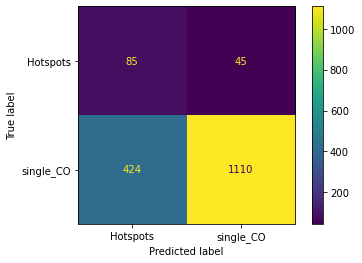

In [15]:
#new model with different scaling & optimizations from 1 round
crossover_xgb2 = xgb.XGBClassifier(objective='binary:logistic', gamma = 0.25, 
                                   scale_pos_weight = 0.1, max_depth = 3,
                                   reg_lambda = 0, learning_rate = 0.1, seed = 100)
crossover_xgb2.fit(X_train, y_train, 
                  verbose = True, 
                  early_stopping_rounds = 10, 
                  eval_metric = 'aucpr', 
                  eval_set = [(X_test, y_test)])
plot_confusion_matrix(crossover_xgb2, X_test, y_test, values_format='d', display_labels=['Hotspots', 'single_CO'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

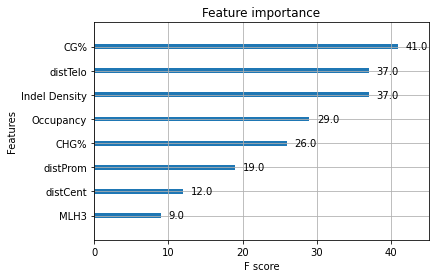

In [16]:
#plotting top 10 important features
plot_importance(crossover_xgb2, max_num_features=10)

In [85]:
#finding the AUC score
y_pred = crossover_xgb2.predict_proba(X_test)[:,1]
print(metrics.roc_auc_score(y_test,y_pred))

0.7622956574064786
